### Обучение моделей

Ниже проводится обучение и оценка качества моделей на подвыборках датасета с фиксированным числом признаков. Реализованы классические модели Random Forest, XGBoost, LightGBM, CatBoost, Logistic Regression и модель TabNet. Для каждой модели вычисляются метрики Accuracy, F1-score, AUC-ROC, а также измеряется время обучения и предсказания. Результаты и матрицы ошибок сохраняются для дальнейшего анализа.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import torch
from scipy.special import softmax
from pytorch_tabnet.abstract_model import TabModel
from pytorch_tabnet.utils import SparsePredictDataset, PredictDataset
from pytorch_tabnet.multiclass_utils import infer_output_dim, check_output_dim
from torch.utils.data import DataLoader
import scipy
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display, Markdown
from tabulate import tabulate
import os

class TabNetClassifier(TabModel):
    def __post_init__(self):
        super(TabNetClassifier, self).__post_init__()
        self._task = 'classification'
        self._default_loss = torch.nn.functional.cross_entropy
        self._default_metric = 'accuracy'

    def weight_updater(self, weights):
        if isinstance(weights, int):
            return weights
        elif isinstance(weights, dict):
            return {self.target_mapper[key]: value for key, value in weights.items()}
        else:
            return weights

    def prepare_target(self, y):
        return np.vectorize(self.target_mapper.get)(y)

    def compute_loss(self, y_pred, y_true):
        return self.loss_fn(y_pred, y_true.long())

    def update_fit_params(self, X_train, y_train, eval_set, weights):
        output_dim, train_labels = infer_output_dim(y_train)
        for X, y in eval_set:
            check_output_dim(train_labels, y)
        self.output_dim = output_dim
        self._default_metric = ('auc' if self.output_dim == 2 else 'accuracy')
        self.classes_ = train_labels
        self.target_mapper = {class_label: index for index, class_label in enumerate(self.classes_)}
        self.preds_mapper = {str(index): class_label for index, class_label in enumerate(self.classes_)}
        self.updated_weights = self.weight_updater(weights)

    def stack_batches(self, list_y_true, list_y_score):
        y_true = np.hstack(list_y_true)
        y_score = np.vstack(list_y_score)
        y_score = softmax(y_score, axis=1)
        return y_true, y_score

    def predict_func(self, outputs):
        outputs = np.argmax(outputs, axis=1)
        return np.vectorize(self.preds_mapper.get)(outputs.astype(str))

    def predict_proba(self, X):
        self.network.eval()
        if scipy.sparse.issparse(X):
            dataloader = DataLoader(SparsePredictDataset(X), batch_size=self.batch_size, shuffle=False)
        else:
            dataloader = DataLoader(PredictDataset(X), batch_size=self.batch_size, shuffle=False)

        results = []
        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()
            output, M_loss = self.network(data)
            predictions = torch.nn.Softmax(dim=1)(output).cpu().detach().numpy()
            results.append(predictions)
        return np.vstack(results)

def train_and_evaluate_classical_models(X_train, y_train, X_test, y_test):
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=123),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                             n_estimators=100, subsample=0.8, colsample_bytree=0.8, 
                             n_jobs=-1, random_state=123),
        "LightGBM": LGBMClassifier(n_estimators=100, subsample=0.8, colsample_bytree=0.8, 
                               n_jobs=-1, random_state=123),
        "CatBoost": CatBoostClassifier(n_estimators=100, subsample=0.8, colsample_bylevel=0.8, 
                                   verbose=0, random_state=123),
        "Logistic Regression": LogisticRegression(max_iter=500, solver="saga", n_jobs=-1, random_state=123)
    }
    
    results = {}
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        start_time = time.time()
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        prediction_time = time.time() - start_time
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        
        results[model_name] = {
            "accuracy": accuracy,
            "f1_score": f1,
            "auc_roc": auc_roc,
            "training_time": training_time,
            "prediction_time": prediction_time,
            "confusion_matrix": cm
        }
        
        print(f"{model_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc_roc:.4f}" if auc_roc is not None else "AUC-ROC: Not available")
        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Prediction Time: {prediction_time:.4f} seconds")
        print("Confusion Matrix:")
        print(cm)
        print("-" * 50)
    
    return results

files_1 = [
    'data_subsets/subset_10000_features_299.csv', 
    'data_subsets/subset_50000_features_299.csv', 
    'data_subsets/subset_100000_features_299.csv',
    'data_subsets/subset_500000_features_299.csv',
    'data_subsets/subset_991320_features_299.csv'
]

files_2 = [
    'data_subsets/subset_10000_features_10.csv', 
    'data_subsets/subset_10000_features_50.csv', 
    'data_subsets/subset_10000_features_100.csv', 
    'data_subsets/subset_10000_features_200.csv', 
    'data_subsets/subset_10000_features_299.csv',
    'data_subsets/subset_50000_features_10.csv', 
    'data_subsets/subset_50000_features_50.csv', 
    'data_subsets/subset_50000_features_100.csv', 
    'data_subsets/subset_50000_features_200.csv', 
    'data_subsets/subset_50000_features_299.csv',
    'data_subsets/subset_100000_features_10.csv', 
    'data_subsets/subset_100000_features_50.csv', 
    'data_subsets/subset_100000_features_100.csv', 
    'data_subsets/subset_100000_features_200.csv', 
    'data_subsets/subset_100000_features_299.csv',
    'data_subsets/subset_500000_features_10.csv',
    'data_subsets/subset_500000_features_50.csv',
    'data_subsets/subset_500000_features_100.csv',
    'data_subsets/subset_500000_features_200.csv',
    'data_subsets/subset_500000_features_299.csv',
    'data_subsets/subset_991320_features_10.csv',
    'data_subsets/subset_991320_features_50.csv',
    'data_subsets/subset_991320_features_100.csv',
    'data_subsets/subset_991320_features_200.csv',
    'data_subsets/subset_991320_features_299.csv',
]

all_results = {}

for file in files_1:
    print(f"Processing file: {file}")
    
    data_1 = pd.read_csv(file)
    
    data_1.columns = data_1.columns.str.replace(" ", "_")
    
    X_1 = data_1.drop(columns=["target"])
    y_1 = data_1["target"]
    
    X_train_1, X_temp_1, y_train_1, y_temp_1 = train_test_split(
        X_1, y_1, test_size=0.3, random_state=123, stratify=y_1
    )
    X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(
        X_temp_1, y_temp_1, test_size=0.5, random_state=123, stratify=y_temp_1
    )

    X_train_np_1 = X_train_1.values
    X_val_np_1 = X_val_1.values
    X_test_np_1 = X_test_1.values
    y_train_np_1 = y_train_1
    y_val_np_1 = y_val_1
    y_test_np_1 = y_test_1
    
    # Обучаем классические модели
    classical_results_1 = train_and_evaluate_classical_models(
    X_train_np_1, y_train_np_1, X_test_np_1, y_test_np_1
    )
    
    # Сохраняем результаты
    for model_name, result in classical_results_1.items():
        all_results[f"{model_name}_{file}"] = result
    
    # Обучаем TabNet
    tabnet_model_1 = TabNetClassifier(
        n_d=16, n_a=16, n_steps=3, gamma=1.7, lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler_params={"mode": "max", "patience": 5, "min_lr": 1e-5, "factor": 0.5}
    )
    
    # Замеряем время обучения
    start_time = time.time()
    
    tabnet_model_1.fit(
        X_train=X_train_np_1, y_train=y_train_np_1,
        eval_set=[(X_val_np_1, y_val_np_1)],
        eval_name=["val"],
        eval_metric=["auc"],
        max_epochs=50,
        patience=15,
        batch_size=2048,
        virtual_batch_size=256
    )
    
    training_time_1 = time.time() - start_time
    print(f"Общее время обучения TabNet: {training_time_1:.2f} секунд")
    
    # Замеряем время предсказания
    start_time = time.time()
    y_pred_proba_1 = tabnet_model_1.predict_proba(X_test_np_1)
    y_pred_proba_pos_1 = y_pred_proba_1[:, 1]
    y_pred_1 = np.argmax(y_pred_proba_1, axis=1)
    cm_tabnet_1 = confusion_matrix(y_test_np_1, y_pred_1)
    prediction_time_1 = time.time() - start_time

    
    # Метрики
    accuracy_1 = accuracy_score(y_test_np_1, y_pred_1)
    f1_1 = f1_score(y_test_np_1, y_pred_1, average='weighted')
    auc_roc_1 = roc_auc_score(y_test_np_1, y_pred_proba_pos_1)
    
    # Сохранение результатов TabNet
    all_results[f"TabNet_{file}"] = {
        "accuracy": accuracy_1,
        "f1_score": f1_1,
        "auc_roc": auc_roc_1,
        "training_time": training_time_1,
        "prediction_time": prediction_time_1,
        "confusion_matrix": cm_tabnet_1
    }

    print(f"TabNet Results:")
    print(f"Accuracy: {accuracy_1:.4f}")
    print(f"F1-Score: {f1_1:.4f}")
    print(f"AUC-ROC: {auc_roc_1:.4f}")
    print(f"Prediction Time: {prediction_time_1:.4f} seconds")
    print("Confusion Matrix (TabNet):")
    print(cm_tabnet_1)
    print("-" * 50)

Processing file: data_subsets/subset_10000_features_299.csv
Training Random Forest...
Random Forest Results:
Accuracy: 0.7100
F1-Score: 0.7099
AUC-ROC: 0.7725
Training Time: 0.52 seconds
Prediction Time: 0.0119 seconds
Confusion Matrix:
[[553 208]
 [227 512]]
--------------------------------------------------
Training XGBoost...
XGBoost Results:
Accuracy: 0.6860
F1-Score: 0.6860
AUC-ROC: 0.7591
Training Time: 1.28 seconds
Prediction Time: 0.0035 seconds
Confusion Matrix:
[[521 240]
 [231 508]]
--------------------------------------------------
Training LightGBM...
[LightGBM] [Info] Number of positive: 3450, number of negative: 3550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53798
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492857 -> initscore=

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7173
F1-Score: 0.7173
AUC-ROC: 0.7839
Training Time: 0.69 seconds
Prediction Time: 0.0090 seconds
Confusion Matrix:
[[541 220]
 [204 535]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7227
F1-Score: 0.7227
AUC-ROC: 0.7865
Training Time: 1.24 seconds
Prediction Time: 0.0054 seconds
Confusion Matrix:
[[547 214]
 [202 537]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7180
F1-Score: 0.7180
AUC-ROC: 0.7923
Training Time: 4.32 seconds
Prediction Time: 0.0033 seconds
Confusion Matrix:
[[547 214]
 [209 530]]
--------------------------------------------------
epoch 0  | loss: 0.88247 | val_auc: 0.5078  |  0:00:00s
epoch 1  | loss: 0.77471 | val_auc: 0.50385 |  0:00:00s
epoch 2  | loss: 0.75771 | val_auc: 0.54147 |  0:00:01s
epoch 3  | loss: 0.71524 | val_auc: 0.61147 |  0:00:01s
epoch 4  | loss: 0.6986  | val_auc: 0.63481 |  0:00:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17294, number of negative: 17706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57161
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494114 -> initscore=-0.023544
[LightGBM] [Info] Start training from score -0.023544


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7291
F1-Score: 0.7291
AUC-ROC: 0.8092
Training Time: 1.25 seconds
Prediction Time: 0.0551 seconds
Confusion Matrix:
[[2764 1031]
 [1001 2704]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7224
F1-Score: 0.7224
AUC-ROC: 0.8004
Training Time: 2.10 seconds
Prediction Time: 0.0277 seconds
Confusion Matrix:
[[2748 1047]
 [1035 2670]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7357
F1-Score: 0.7357
AUC-ROC: 0.8145
Training Time: 22.07 seconds
Prediction Time: 0.0103 seconds
Confusion Matrix:
[[2802  993]
 [ 989 2716]]
--------------------------------------------------
epoch 0  | loss: 0.75358 | val_auc: 0.64695 |  0:00:01s
epoch 1  | loss: 0.64335 | val_auc: 0.69163 |  0:00:02s
epoch 2  | loss: 0.61349 | val_auc: 0.71095 |  0:00:03s
epoch 3  | loss: 0.60303 | val_auc: 0.72252 |  0:00:04s
epoch 4  | loss: 0.59129 | val_auc: 0.7

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 34794, number of negative: 35206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58373
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497057 -> initscore=-0.011772
[LightGBM] [Info] Start training from score -0.011772


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7347
F1-Score: 0.7347
AUC-ROC: 0.8155
Training Time: 2.32 seconds
Prediction Time: 0.0656 seconds
Confusion Matrix:
[[5492 2052]
 [1928 5528]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7269
F1-Score: 0.7269
AUC-ROC: 0.8055
Training Time: 2.08 seconds
Prediction Time: 0.0118 seconds
Confusion Matrix:
[[5488 2056]
 [2040 5416]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7362
F1-Score: 0.7362
AUC-ROC: 0.8187
Training Time: 44.84 seconds
Prediction Time: 0.0094 seconds
Confusion Matrix:
[[5526 2018]
 [1939 5517]]
--------------------------------------------------
epoch 0  | loss: 0.71356 | val_auc: 0.65028 |  0:00:02s
epoch 1  | loss: 0.61512 | val_auc: 0.71659 |  0:00:04s
epoch 2  | loss: 0.59144 | val_auc: 0.71779 |  0:00:07s
epoch 3  | loss: 0.58096 | val_auc: 0.7141  |  0:00:09s
epoch 4  | loss: 0.57912 | val_auc: 0.7

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 174739, number of negative: 175261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59419
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499254 -> initscore=-0.002983
[LightGBM] [Info] Start training from score -0.002983


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7365
F1-Score: 0.7365
AUC-ROC: 0.8207
Training Time: 9.85 seconds
Prediction Time: 0.3339 seconds
Confusion Matrix:
[[27491 10065]
 [ 9697 27747]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7343
F1-Score: 0.7343
AUC-ROC: 0.8181
Training Time: 5.90 seconds
Prediction Time: 0.0472 seconds
Confusion Matrix:
[[27527 10029]
 [ 9897 27547]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7375
F1-Score: 0.7375
AUC-ROC: 0.8201
Training Time: 239.60 seconds
Prediction Time: 0.0768 seconds
Confusion Matrix:
[[27634  9922]
 [ 9769 27675]]
--------------------------------------------------
epoch 0  | loss: 0.60332 | val_auc: 0.77578 |  0:00:17s
epoch 1  | loss: 0.55362 | val_auc: 0.79454 |  0:00:41s
epoch 2  | loss: 0.54664 | val_auc: 0.80065 |  0:01:01s
epoch 3  | loss: 0.53994 | val_auc: 0.8076  |  0:01:18s
epoch 4  | loss: 0.53397 |

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 346833, number of negative: 347091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59396
[LightGBM] [Info] Number of data points in the train set: 693924, number of used features: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499814 -> initscore=-0.000744
[LightGBM] [Info] Start training from score -0.000744


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7399
F1-Score: 0.7399
AUC-ROC: 0.8237
Training Time: 17.95 seconds
Prediction Time: 0.6169 seconds
Confusion Matrix:
[[54671 19706]
 [18968 55353]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7395
F1-Score: 0.7395
AUC-ROC: 0.8225
Training Time: 11.18 seconds
Prediction Time: 0.0830 seconds
Confusion Matrix:
[[54981 19396]
 [19343 54978]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7384
F1-Score: 0.7384
AUC-ROC: 0.8201
Training Time: 513.38 seconds
Prediction Time: 0.1349 seconds
Confusion Matrix:
[[54843 19534]
 [19369 54952]]
--------------------------------------------------
epoch 0  | loss: 0.59099 | val_auc: 0.78363 |  0:00:25s
epoch 1  | loss: 0.5446  | val_auc: 0.80622 |  0:00:49s
epoch 2  | loss: 0.52965 | val_auc: 0.81431 |  0:01:13s
epoch 3  | loss: 0.5244  | val_auc: 0.81698 |  0:01:38s
epoch 4  | loss: 0.52247

### Визуализация результатов (files_1)

Построены:
- матрицы ошибок 
- графики Accuracy, F1-score, AUC-ROC,времени обучения и времени предсказания

CONFUSION MATRICES: files_1


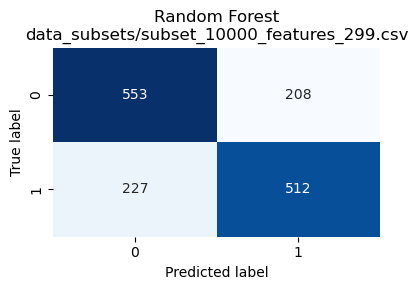

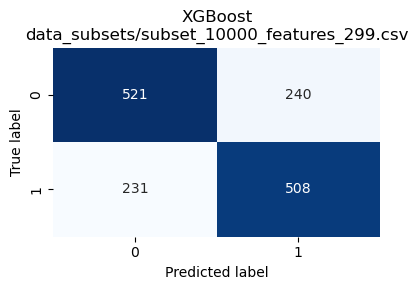

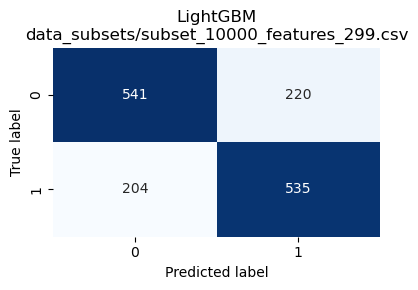

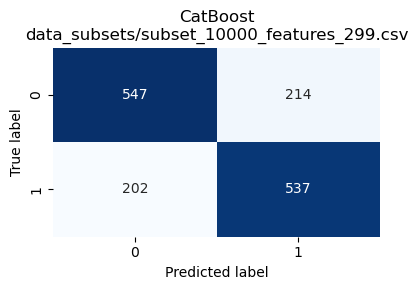

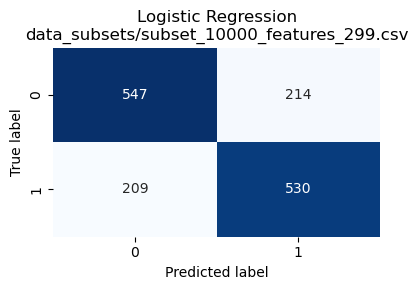

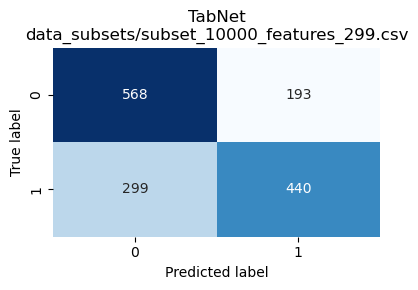

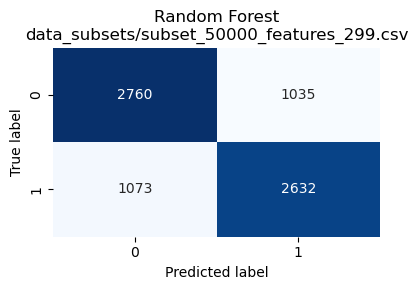

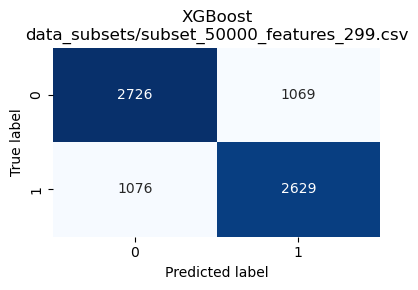

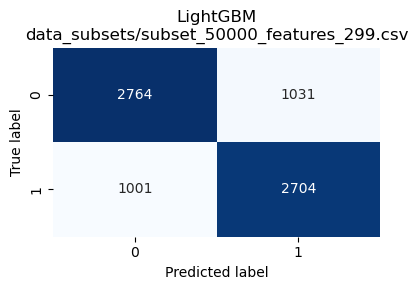

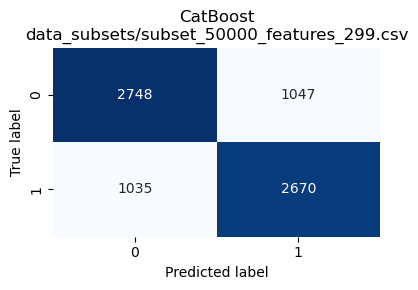

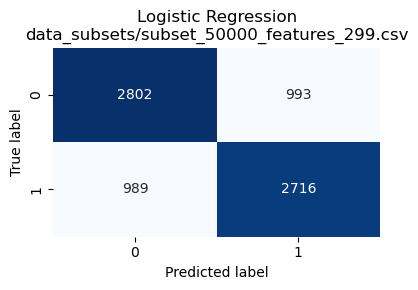

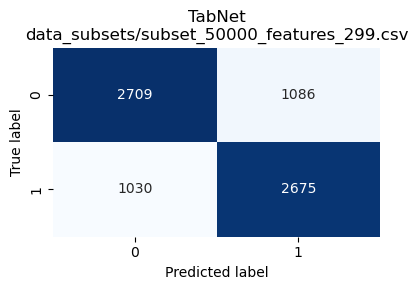

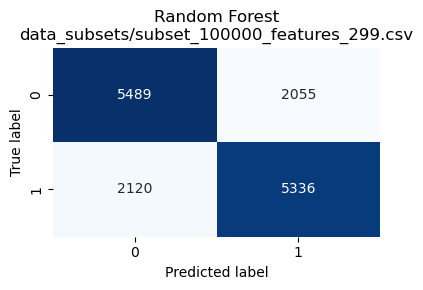

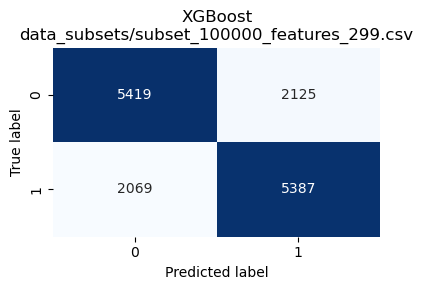

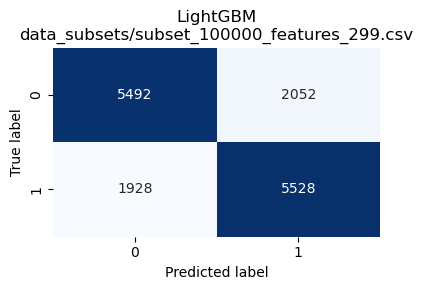

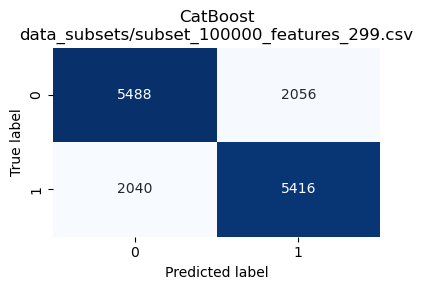

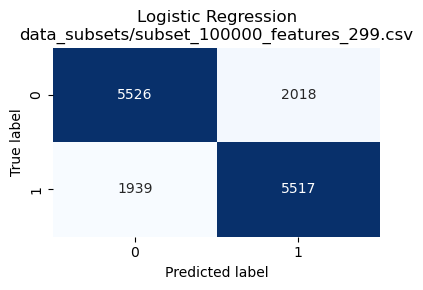

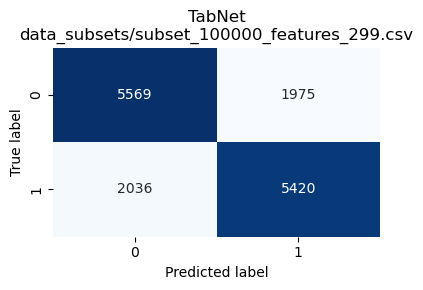

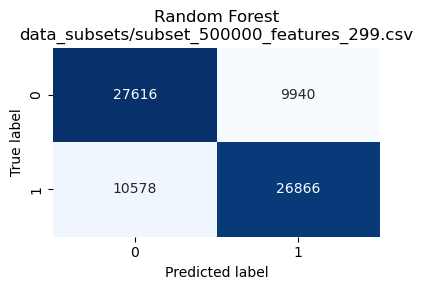

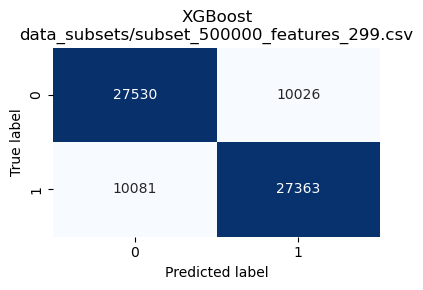

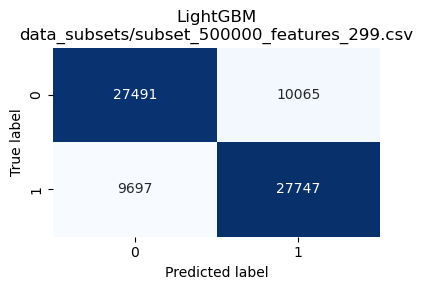

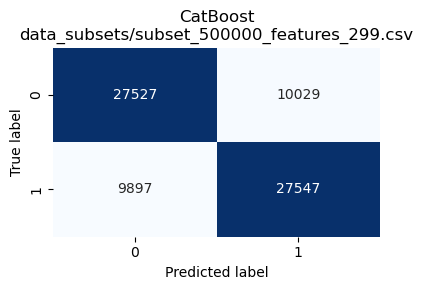

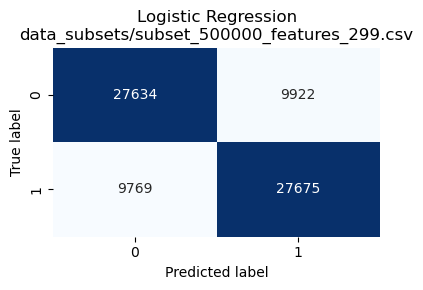

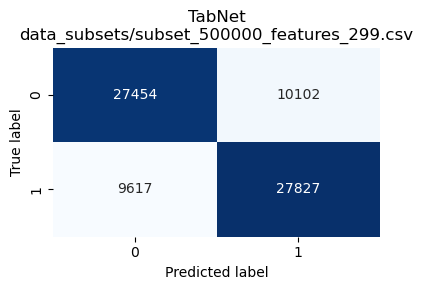

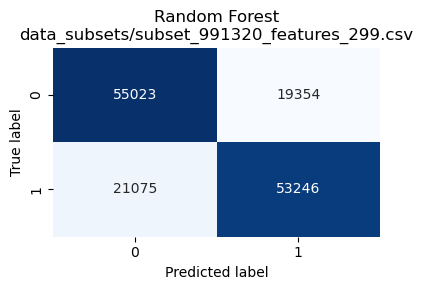

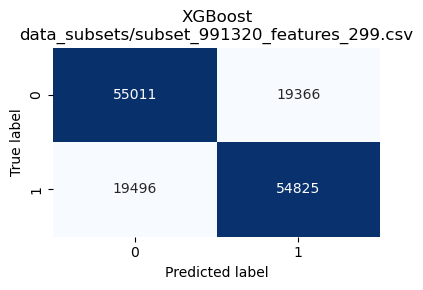

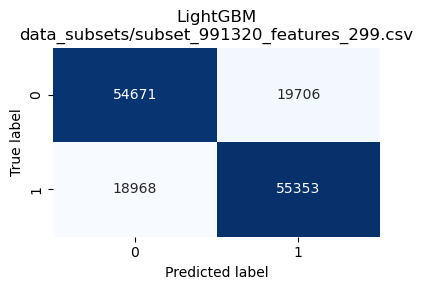

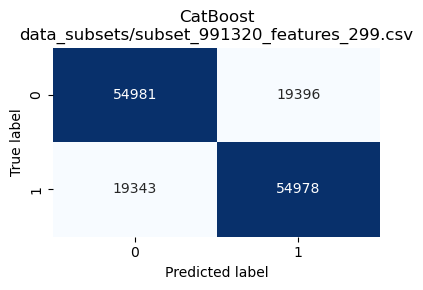

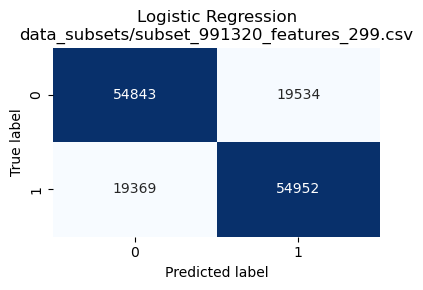

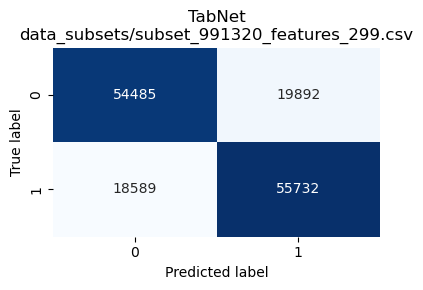

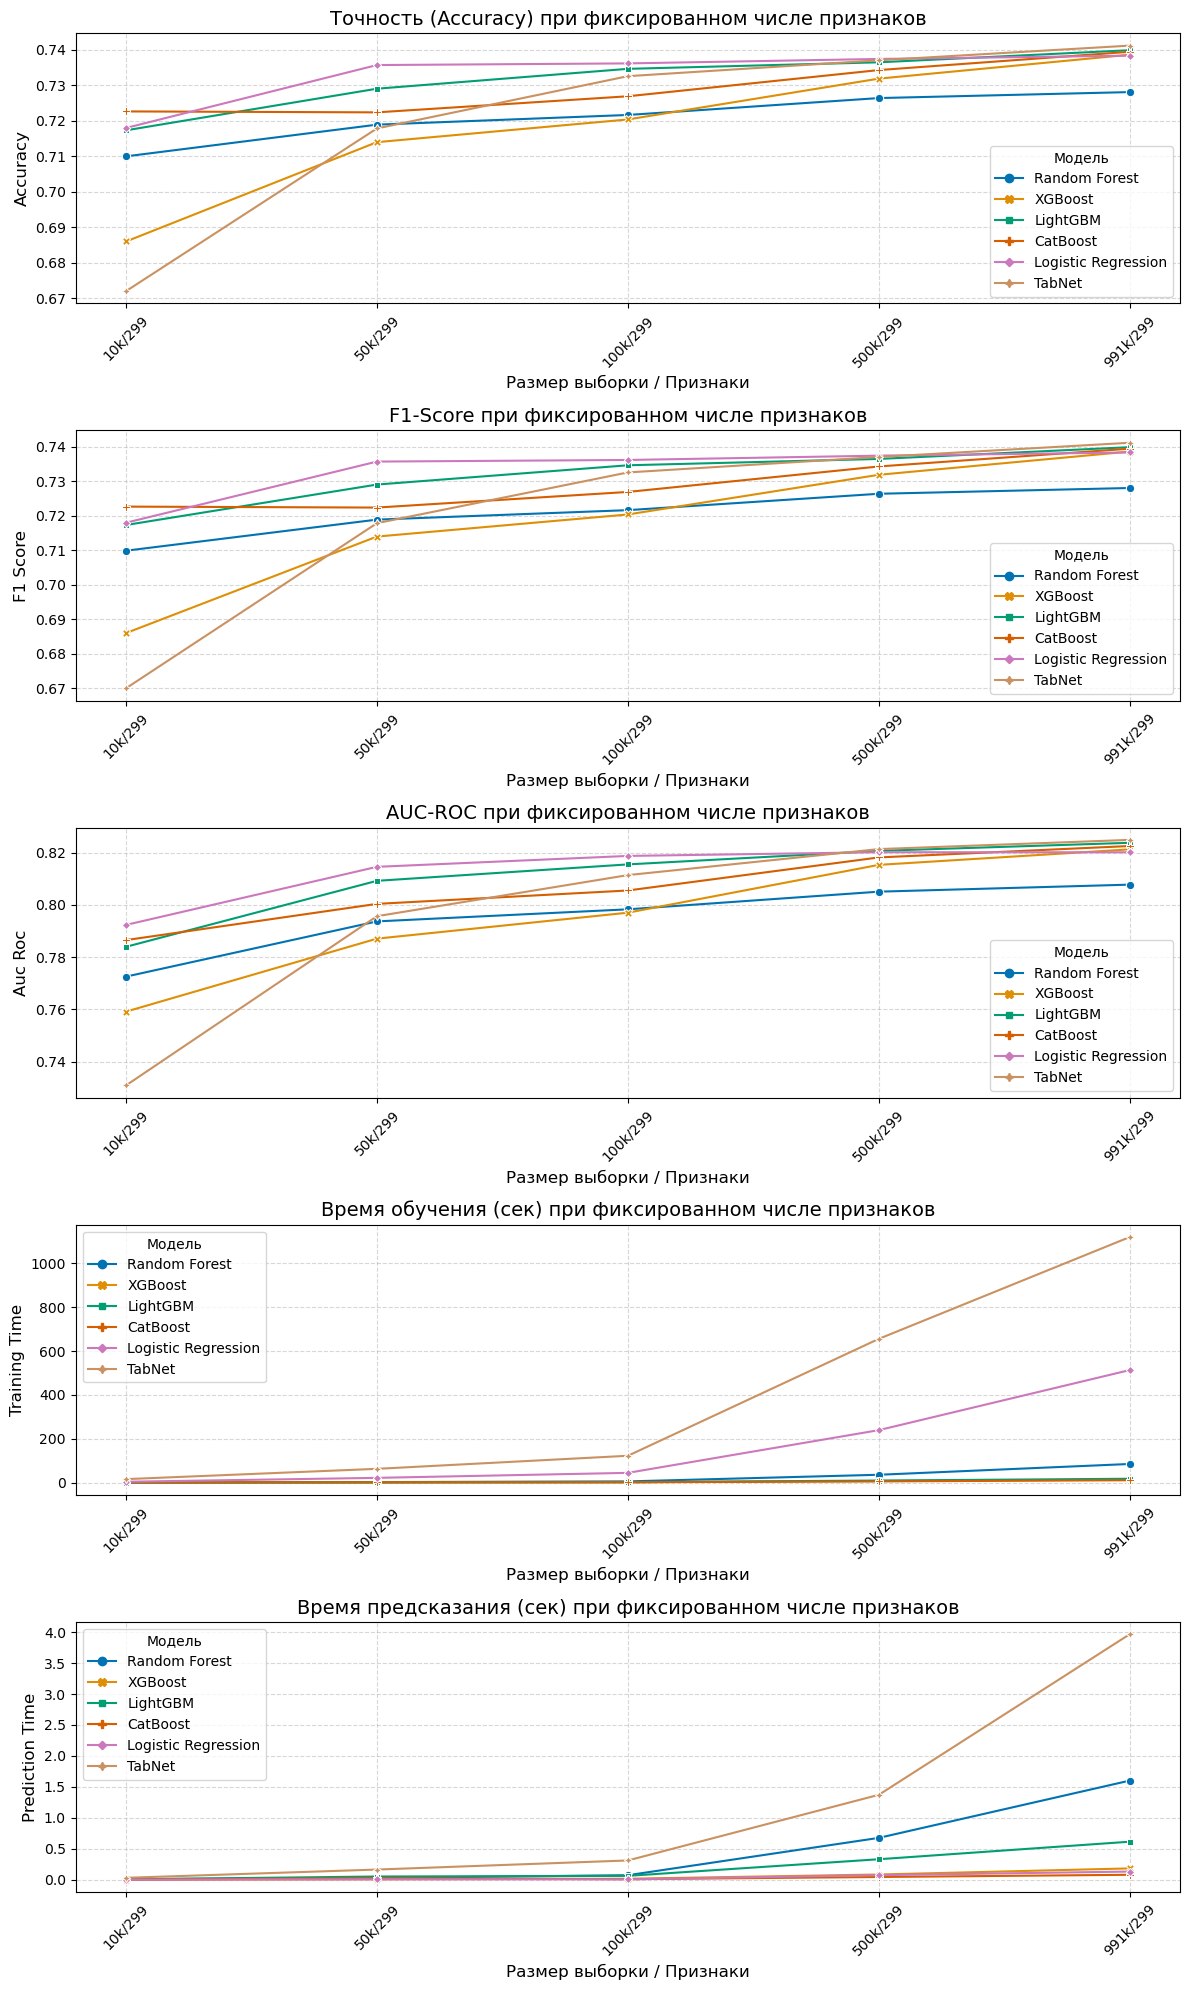

In [2]:
results_list = []
for key, value in all_results.items():
    model_name, file = key.split("_", 1)
    results_list.append({
        "model": model_name,
        "file": file,
        "accuracy": value["accuracy"],
        "f1_score": value["f1_score"],
        "auc_roc": value["auc_roc"],
        "training_time": value.get("training_time", None),  
        "prediction_time": value.get("prediction_time", None),
        "confusion_matrix": value.get("confusion_matrix", None)
    })

results_df = pd.DataFrame(results_list)

def rename_file_column(df):
    def transform_filename(filename):
        base_name = os.path.basename(filename) 
        parts = base_name.replace(".csv", "").split("_")
        size = int(parts[1]) // 1000
        features = parts[3]
        return f"{size}k/{features}"
    
    df["file"] = df["file"].apply(transform_filename)
    return df

def plot_confusion_matrix(cm, model_name, file_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False
    )
    plt.title(f"{model_name}\n{file_name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

results_df = rename_file_column(results_df)

print("=" * 80)
print("CONFUSION MATRICES: files_1")
print("=" * 80)

for key, value in all_results.items():
    cm = value.get("confusion_matrix", None)
    if cm is None:
        continue

    model_name, file_name = key.split("_", 1)
    plot_confusion_matrix(
        cm=cm,
        model_name=model_name,
        file_name=file_name
    )

palette = sns.color_palette("colorblind")

plot_titles = [
    "Точность (Accuracy)",
    "F1-Score",
    "AUC-ROC",
    "Время обучения (сек)",
    "Время предсказания (сек)"
]
metrics = ["accuracy", "f1_score", "auc_roc", "training_time", "prediction_time"]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20))

for idx, ax in enumerate(axes):
    metric = metrics[idx]
    
    if metric not in results_df.columns:
        continue
    
    sns.lineplot(
        data=results_df,
        x='file',
        y=metric,
        hue='model',
        style='model',
        markers=True,
        dashes=False,
        palette=palette,
        ax=ax
    )
    
    ax.set_title(f"{plot_titles[idx]} при фиксированном числе признаков", fontsize=14)
    ax.set_xlabel('Размер выборки / Признаки', fontsize=12)
    ax.set_ylabel(metric.replace("_", " ").title(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Модель', loc='best')

plt.tight_layout()
plt.show()

### Табличное сравнение моделей (files_1)

Формируем итоговые таблицы сравнения моделей по каждой метрике.

In [3]:
metrics_for_tables = ["accuracy", "f1_score", "auc_roc", "training_time", "prediction_time"]

print("Итоговые таблицы по метрикам для каждого файла")

for metric in metrics_for_tables:
    print(f"Топ моделей по {metric.replace('_', ' ').title()}")
    
    metric_table = results_df[["model", "file", metric]].copy()
    metric_table = metric_table.dropna(subset=[metric])
    metric_table = metric_table.sort_values(by=metric, ascending=False)
    
    table_str = tabulate(metric_table, headers='keys', tablefmt='github', showindex=False, floatfmt=".4f")
    
    print(table_str)
    print("\n")

Итоговые таблицы по метрикам для каждого файла
Топ моделей по Accuracy
| model               | file     |   accuracy |
|---------------------|----------|------------|
| TabNet              | 991k/299 |     0.7412 |
| LightGBM            | 991k/299 |     0.7399 |
| CatBoost            | 991k/299 |     0.7395 |
| XGBoost             | 991k/299 |     0.7387 |
| Logistic Regression | 991k/299 |     0.7384 |
| Logistic Regression | 500k/299 |     0.7375 |
| TabNet              | 500k/299 |     0.7371 |
| LightGBM            | 500k/299 |     0.7365 |
| Logistic Regression | 100k/299 |     0.7362 |
| Logistic Regression | 50k/299  |     0.7357 |
| LightGBM            | 100k/299 |     0.7347 |
| CatBoost            | 500k/299 |     0.7343 |
| TabNet              | 100k/299 |     0.7326 |
| XGBoost             | 500k/299 |     0.7319 |
| LightGBM            | 50k/299  |     0.7291 |
| Random Forest       | 991k/299 |     0.7281 |
| CatBoost            | 100k/299 |     0.7269 |
| Random Forest  

### Эксперименты с переменным числом признаков


Проводим обучение и оценку моделей на подвыборках с переменным числом признаков

In [4]:
all_results_var_features = {}

for file in files_2:
    print(f"Processing file: {file}")
    
    data_2 = pd.read_csv(file)
    
    data_2.columns = data_2.columns.str.replace(" ", "_")
    
    X_2 = data_2.drop(columns=["target"])
    y_2 = data_2["target"]
    
    X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(
        X_2, y_2, test_size=0.3, random_state=123, stratify=y_2
    )
    X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(
        X_temp_2, y_temp_2, test_size=0.5, random_state=123, stratify=y_temp_2
    )

    X_train_np_2 = X_train_2.values
    X_val_np_2 = X_val_2.values
    X_test_np_2 = X_test_2.values
    y_train_np_2 = y_train_2
    y_val_np_2 = y_val_2
    y_test_np_2 = y_test_2
    
    # Обучаем классические модели
    classical_results_2 = train_and_evaluate_classical_models(
    X_train_np_2, y_train_np_2, X_test_np_2, y_test_np_2
    )
    
    # Сохраняем результаты
    for model_name, result in classical_results_2.items():
        all_results_var_features[f"{model_name}_{file}"] = result
    
    # Обучаем TabNet
    tabnet_model_2 = TabNetClassifier(
        n_d=16, n_a=16, n_steps=3, gamma=1.7, lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler_params={"mode": "max", "patience": 5, "min_lr": 1e-5, "factor": 0.5}
    )
    
    # Замеряем время обучения
    start_time = time.time()
    
    tabnet_model_2.fit(
        X_train=X_train_np_2, y_train=y_train_np_2,
        eval_set=[(X_val_np_2, y_val_np_2)],
        eval_name=["val"],
        eval_metric=["auc"],
        max_epochs=50,
        patience=15,
        batch_size=2048,
        virtual_batch_size=256
    )
    
    training_time_2 = time.time() - start_time
    print(f"Общее время обучения TabNet: {training_time_2:.2f} секунд")
    
    # Замеряем время предсказания
    start_time = time.time()
    y_pred_proba_2 = tabnet_model_2.predict_proba(X_test_np_2)
    y_pred_proba_pos_2 = y_pred_proba_2[:, 1]
    y_pred_2 = np.argmax(y_pred_proba_2, axis=1)
    cm_tabnet_2 = confusion_matrix(y_test_np_2, y_pred_2)
    prediction_time_2 = time.time() - start_time

    
    # Метрики
    accuracy_2 = accuracy_score(y_test_np_2, y_pred_2)
    f1_2 = f1_score(y_test_np_2, y_pred_2, average='weighted')
    auc_roc_2 = roc_auc_score(y_test_np_2, y_pred_proba_pos_2)
    
    # Сохранение результатов TabNet
    all_results_var_features[f"TabNet_{file}"] = {
        "accuracy": accuracy_2,
        "f1_score": f1_2,
        "auc_roc": auc_roc_2,
        "training_time": training_time_2,
        "prediction_time": prediction_time_2,
        "confusion_matrix": cm_tabnet_2
    }

    print(f"TabNet Results:")
    print(f"Accuracy: {accuracy_2:.4f}")
    print(f"F1-Score: {f1_2:.4f}")
    print(f"AUC-ROC: {auc_roc_2:.4f}")
    print(f"Prediction Time: {prediction_time_2:.4f} seconds")
    print("Confusion Matrix (TabNet):")
    print(cm_tabnet_2)
    print("-" * 50)

Processing file: data_subsets/subset_10000_features_10.csv
Training Random Forest...
Random Forest Results:
Accuracy: 0.6507
F1-Score: 0.6506
AUC-ROC: 0.6990
Training Time: 0.08 seconds
Prediction Time: 0.0104 seconds
Confusion Matrix:
[[481 280]
 [244 495]]
--------------------------------------------------
Training XGBoost...
XGBoost Results:
Accuracy: 0.6373
F1-Score: 0.6371
AUC-ROC: 0.6850
Training Time: 0.04 seconds
Prediction Time: 0.0018 seconds
Confusion Matrix:
[[462 299]
 [245 494]]
--------------------------------------------------
Training LightGBM...
[LightGBM] [Info] Number of positive: 3450, number of negative: 3550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 10
[LightGBM]

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.6700
F1-Score: 0.6693
AUC-ROC: 0.7134
Training Time: 0.13 seconds
Prediction Time: 0.0041 seconds
Confusion Matrix:
[[472 289]
 [206 533]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.6787
F1-Score: 0.6778
AUC-ROC: 0.7304
Training Time: 0.16 seconds
Prediction Time: 0.0027 seconds
Confusion Matrix:
[[476 285]
 [197 542]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6827
F1-Score: 0.6827
AUC-ROC: 0.7346
Training Time: 0.01 seconds
Prediction Time: 0.0019 seconds
Confusion Matrix:
[[519 242]
 [234 505]]
--------------------------------------------------
epoch 0  | loss: 0.89291 | val_auc: 0.61317 |  0:00:00s
epoch 1  | loss: 0.66607 | val_auc: 0.6863  |  0:00:00s
epoch 2  | loss: 0.62421 | val_auc: 0.71801 |  0:00:00s
epoch 3  | loss: 0.62627 | val_auc: 0.72553 |  0:00:00s
epoch 4  | loss: 0.60762 | val_auc: 0.73742 |  0:00:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CatBoost Results:
Accuracy: 0.7247
F1-Score: 0.7247
AUC-ROC: 0.7949
Training Time: 0.25 seconds
Prediction Time: 0.0035 seconds
Confusion Matrix:
[[546 215]
 [198 541]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7267
F1-Score: 0.7267
AUC-ROC: 0.8037
Training Time: 0.21 seconds
Prediction Time: 0.0149 seconds
Confusion Matrix:
[[554 207]
 [203 536]]
--------------------------------------------------
epoch 0  | loss: 1.26052 | val_auc: 0.54706 |  0:00:00s
epoch 1  | loss: 0.80334 | val_auc: 0.62169 |  0:00:00s
epoch 2  | loss: 0.70975 | val_auc: 0.65151 |  0:00:00s
epoch 3  | loss: 0.66379 | val_auc: 0.6633  |  0:00:00s
epoch 4  | loss: 0.64748 | val_auc: 0.68341 |  0:00:00s
epoch 5  | loss: 0.62634 | val_auc: 0.69505 |  0:00:00s
epoch 6  | loss: 0.61741 | val_auc: 0.70934 |  0:00:00s
epoch 7  | loss: 0.60648 | val_auc: 0.71594 |  0:00:00s
epoch 8  | loss: 0.60333 | val_auc: 0.71979 |  0:00:00s
epoch 9  | lo

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3450, number of negative: 3550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14045
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492857 -> initscore=-0.028573
[LightGBM] [Info] Start training from score -0.028573
LightGBM Results:
Accuracy: 0.7180
F1-Score: 0.7180
AUC-ROC: 0.7948
Training Time: 0.18 seconds
Prediction Time: 0.0062 seconds
Confusion Matrix:
[[538 223]
 [200 539]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7100
F1-Score: 0.7099
AUC-ROC: 0.7900
Training Time: 0.37 seconds
Prediction Time: 0.0040 seconds
Confusion Matrix:
[[524 237]
 [198 541]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regre

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7227
F1-Score: 0.7227
AUC-ROC: 0.7917
Training Time: 0.36 seconds
Prediction Time: 0.0077 seconds
Confusion Matrix:
[[548 213]
 [203 536]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7107
F1-Score: 0.7106
AUC-ROC: 0.7859
Training Time: 0.66 seconds
Prediction Time: 0.0051 seconds
Confusion Matrix:
[[528 233]
 [201 538]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7227
F1-Score: 0.7227
AUC-ROC: 0.7943
Training Time: 2.76 seconds
Prediction Time: 0.0009 seconds
Confusion Matrix:
[[547 214]
 [202 537]]
--------------------------------------------------
epoch 0  | loss: 1.11607 | val_auc: 0.51331 |  0:00:00s
epoch 1  | loss: 0.91122 | val_auc: 0.50347 |  0:00:00s
epoch 2  | loss: 0.87311 | val_auc: 0.53137 |  0:00:00s
epoch 3  | loss: 0.78339 | val_auc: 0.60143 |  0:00:00s
epoch 4  | loss: 0.73361 | val_auc: 0.64087 |  0:00:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7173
F1-Score: 0.7173
AUC-ROC: 0.7839
Training Time: 0.64 seconds
Prediction Time: 0.0067 seconds
Confusion Matrix:
[[541 220]
 [204 535]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7227
F1-Score: 0.7227
AUC-ROC: 0.7865
Training Time: 1.03 seconds
Prediction Time: 0.0065 seconds
Confusion Matrix:
[[547 214]
 [202 537]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7180
F1-Score: 0.7180
AUC-ROC: 0.7923
Training Time: 4.04 seconds
Prediction Time: 0.0012 seconds
Confusion Matrix:
[[547 214]
 [209 530]]
--------------------------------------------------
epoch 0  | loss: 0.88247 | val_auc: 0.5078  |  0:00:00s
epoch 1  | loss: 0.77471 | val_auc: 0.50385 |  0:00:00s
epoch 2  | loss: 0.75771 | val_auc: 0.54147 |  0:00:00s
epoch 3  | loss: 0.71524 | val_auc: 0.61147 |  0:00:01s
epoch 4  | loss: 0.6986  | val_auc: 0.63481 |  0:00:

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.6957
F1-Score: 0.6956
AUC-ROC: 0.7590
Training Time: 0.31 seconds
Prediction Time: 0.0169 seconds
Confusion Matrix:
[[2542 1253]
 [1029 2676]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7004
F1-Score: 0.7001
AUC-ROC: 0.7598
Training Time: 0.21 seconds
Prediction Time: 0.0046 seconds
Confusion Matrix:
[[2534 1261]
 [ 986 2719]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6981
F1-Score: 0.6981
AUC-ROC: 0.7575
Training Time: 0.04 seconds
Prediction Time: 0.0019 seconds
Confusion Matrix:
[[2659 1136]
 [1128 2577]]
--------------------------------------------------
epoch 0  | loss: 0.67848 | val_auc: 0.72955 |  0:00:00s
epoch 1  | loss: 0.59619 | val_auc: 0.74787 |  0:00:00s
epoch 2  | loss: 0.58874 | val_auc: 0.75326 |  0:00:01s
epoch 3  | loss: 0.58285 | val_auc: 0.75693 |  0:00:01s
epoch 4  | loss: 0.58158 | val_auc: 0.75

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17294, number of negative: 17706
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5832
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494114 -> initscore=-0.023544
[LightGBM] [Info] Start training from score -0.023544


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7344
F1-Score: 0.7344
AUC-ROC: 0.8130
Training Time: 0.56 seconds
Prediction Time: 0.0228 seconds
Confusion Matrix:
[[2808  987]
 [1005 2700]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7248
F1-Score: 0.7248
AUC-ROC: 0.8046
Training Time: 0.48 seconds
Prediction Time: 0.0047 seconds
Confusion Matrix:
[[2759 1036]
 [1028 2677]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7337
F1-Score: 0.7337
AUC-ROC: 0.8127
Training Time: 0.53 seconds
Prediction Time: 0.0199 seconds
Confusion Matrix:
[[2771 1024]
 [ 973 2732]]
--------------------------------------------------
epoch 0  | loss: 0.80264 | val_auc: 0.69816 |  0:00:00s
epoch 1  | loss: 0.61091 | val_auc: 0.7465  |  0:00:01s
epoch 2  | loss: 0.58497 | val_auc: 0.76895 |  0:00:01s
epoch 3  | loss: 0.5699  | val_auc: 0.77984 |  0:00:01s
epoch 4  | loss: 0.56085 | val_auc: 0.78

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7301
F1-Score: 0.7301
AUC-ROC: 0.8093
Training Time: 0.89 seconds
Prediction Time: 0.0254 seconds
Confusion Matrix:
[[2777 1018]
 [1006 2699]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7289
F1-Score: 0.7289
AUC-ROC: 0.8027
Training Time: 0.69 seconds
Prediction Time: 0.0060 seconds
Confusion Matrix:
[[2754 1041]
 [ 992 2713]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7357
F1-Score: 0.7357
AUC-ROC: 0.8141
Training Time: 3.16 seconds
Prediction Time: 0.0050 seconds
Confusion Matrix:
[[2769 1026]
 [ 956 2749]]
--------------------------------------------------
epoch 0  | loss: 0.75893 | val_auc: 0.60931 |  0:00:00s
epoch 1  | loss: 0.63304 | val_auc: 0.67145 |  0:00:01s
epoch 2  | loss: 0.60468 | val_auc: 0.73069 |  0:00:01s
epoch 3  | loss: 0.58759 | val_auc: 0.74985 |  0:00:02s
epoch 4  | loss: 0.5761  | val_auc: 0.76

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17294, number of negative: 17706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34112
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494114 -> initscore=-0.023544
[LightGBM] [Info] Start training from score -0.023544


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7303
F1-Score: 0.7303
AUC-ROC: 0.8124
Training Time: 1.41 seconds
Prediction Time: 0.0289 seconds
Confusion Matrix:
[[2795 1000]
 [1023 2682]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7253
F1-Score: 0.7253
AUC-ROC: 0.8028
Training Time: 1.21 seconds
Prediction Time: 0.0073 seconds
Confusion Matrix:
[[2775 1020]
 [1040 2665]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7341
F1-Score: 0.7341
AUC-ROC: 0.8135
Training Time: 15.08 seconds
Prediction Time: 0.0021 seconds
Confusion Matrix:
[[2768 1027]
 [ 967 2738]]
--------------------------------------------------
epoch 0  | loss: 0.82925 | val_auc: 0.66377 |  0:00:01s
epoch 1  | loss: 0.64985 | val_auc: 0.73103 |  0:00:02s
epoch 2  | loss: 0.60652 | val_auc: 0.75894 |  0:00:03s
epoch 3  | loss: 0.5795  | val_auc: 0.7767  |  0:00:04s
epoch 4  | loss: 0.57157 | val_auc: 0.7

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17294, number of negative: 17706
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57161
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494114 -> initscore=-0.023544
[LightGBM] [Info] Start training from score -0.023544


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7291
F1-Score: 0.7291
AUC-ROC: 0.8092
Training Time: 1.97 seconds
Prediction Time: 0.0300 seconds
Confusion Matrix:
[[2764 1031]
 [1001 2704]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7224
F1-Score: 0.7224
AUC-ROC: 0.8004
Training Time: 1.56 seconds
Prediction Time: 0.0077 seconds
Confusion Matrix:
[[2748 1047]
 [1035 2670]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7357
F1-Score: 0.7357
AUC-ROC: 0.8145
Training Time: 21.86 seconds
Prediction Time: 0.0073 seconds
Confusion Matrix:
[[2802  993]
 [ 989 2716]]
--------------------------------------------------
epoch 0  | loss: 0.75358 | val_auc: 0.64695 |  0:00:01s
epoch 1  | loss: 0.64335 | val_auc: 0.69163 |  0:00:02s
epoch 2  | loss: 0.61349 | val_auc: 0.71095 |  0:00:03s
epoch 3  | loss: 0.60303 | val_auc: 0.72252 |  0:00:05s
epoch 4  | loss: 0.59129 | val_auc: 0.7

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7056
F1-Score: 0.7048
AUC-ROC: 0.7645
Training Time: 0.40 seconds
Prediction Time: 0.0304 seconds
Confusion Matrix:
[[4912 2632]
 [1784 5672]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7062
F1-Score: 0.7055
AUC-ROC: 0.7623
Training Time: 0.29 seconds
Prediction Time: 0.0050 seconds
Confusion Matrix:
[[4952 2592]
 [1815 5641]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.6995
F1-Score: 0.6994
AUC-ROC: 0.7577
Training Time: 0.09 seconds
Prediction Time: 0.0067 seconds
Confusion Matrix:
[[5143 2401]
 [2107 5349]]
--------------------------------------------------
epoch 0  | loss: 0.63883 | val_auc: 0.74682 |  0:00:00s
epoch 1  | loss: 0.58301 | val_auc: 0.75561 |  0:00:01s
epoch 2  | loss: 0.57867 | val_auc: 0.75719 |  0:00:02s
epoch 3  | loss: 0.57805 | val_auc: 0.75751 |  0:00:03s
epoch 4  | loss: 0.57587 | val_auc: 0.75

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7350
F1-Score: 0.7350
AUC-ROC: 0.8166
Training Time: 0.87 seconds
Prediction Time: 0.0421 seconds
Confusion Matrix:
[[5503 2041]
 [1934 5522]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7299
F1-Score: 0.7299
AUC-ROC: 0.8099
Training Time: 0.68 seconds
Prediction Time: 0.0050 seconds
Confusion Matrix:
[[5486 2058]
 [1993 5463]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7331
F1-Score: 0.7331
AUC-ROC: 0.8141
Training Time: 0.60 seconds
Prediction Time: 0.0019 seconds
Confusion Matrix:
[[5478 2066]
 [1938 5518]]
--------------------------------------------------
epoch 0  | loss: 0.70581 | val_auc: 0.73613 |  0:00:01s
epoch 1  | loss: 0.57966 | val_auc: 0.76992 |  0:00:01s
epoch 2  | loss: 0.56218 | val_auc: 0.78144 |  0:00:02s
epoch 3  | loss: 0.55012 | val_auc: 0.78756 |  0:00:03s
epoch 4  | loss: 0.54149 | val_auc: 0.79

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15555
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497057 -> initscore=-0.011772
[LightGBM] [Info] Start training from score -0.011772


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7335
F1-Score: 0.7335
AUC-ROC: 0.8159
Training Time: 1.35 seconds
Prediction Time: 0.0434 seconds
Confusion Matrix:
[[5504 2040]
 [1958 5498]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7292
F1-Score: 0.7292
AUC-ROC: 0.8074
Training Time: 0.95 seconds
Prediction Time: 0.0064 seconds
Confusion Matrix:
[[5501 2043]
 [2019 5437]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7361
F1-Score: 0.7361
AUC-ROC: 0.8159
Training Time: 2.77 seconds
Prediction Time: 0.0026 seconds
Confusion Matrix:
[[5497 2047]
 [1912 5544]]
--------------------------------------------------
epoch 0  | loss: 0.71039 | val_auc: 0.66616 |  0:00:01s
epoch 1  | loss: 0.60716 | val_auc: 0.71836 |  0:00:02s
epoch 2  | loss: 0.58005 | val_auc: 0.74099 |  0:00:03s
epoch 3  | loss: 0.56201 | val_auc: 0.7657  |  0:00:04s
epoch 4  | loss: 0.55803 | val_auc: 0.76

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 34794, number of negative: 35206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35079
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497057 -> initscore=-0.011772
[LightGBM] [Info] Start training from score -0.011772


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7331
F1-Score: 0.7331
AUC-ROC: 0.8164
Training Time: 2.20 seconds
Prediction Time: 0.0497 seconds
Confusion Matrix:
[[5490 2054]
 [1949 5507]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7290
F1-Score: 0.7290
AUC-ROC: 0.8046
Training Time: 1.57 seconds
Prediction Time: 0.0112 seconds
Confusion Matrix:
[[5495 2049]
 [2016 5440]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7347
F1-Score: 0.7347
AUC-ROC: 0.8161
Training Time: 31.19 seconds
Prediction Time: 0.0137 seconds
Confusion Matrix:
[[5486 2058]
 [1921 5535]]
--------------------------------------------------
epoch 0  | loss: 0.74036 | val_auc: 0.69931 |  0:00:01s
epoch 1  | loss: 0.59684 | val_auc: 0.71541 |  0:00:03s
epoch 2  | loss: 0.56488 | val_auc: 0.77326 |  0:00:05s
epoch 3  | loss: 0.55895 | val_auc: 0.78023 |  0:00:07s
epoch 4  | loss: 0.55466 | val_auc: 0.7

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 34794, number of negative: 35206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58373
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497057 -> initscore=-0.011772
[LightGBM] [Info] Start training from score -0.011772


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7347
F1-Score: 0.7347
AUC-ROC: 0.8155
Training Time: 3.26 seconds
Prediction Time: 0.0499 seconds
Confusion Matrix:
[[5492 2052]
 [1928 5528]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7269
F1-Score: 0.7269
AUC-ROC: 0.8055
Training Time: 2.05 seconds
Prediction Time: 0.0144 seconds
Confusion Matrix:
[[5488 2056]
 [2040 5416]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7362
F1-Score: 0.7362
AUC-ROC: 0.8187
Training Time: 44.62 seconds
Prediction Time: 0.0048 seconds
Confusion Matrix:
[[5526 2018]
 [1939 5517]]
--------------------------------------------------
epoch 0  | loss: 0.71356 | val_auc: 0.65028 |  0:00:02s
epoch 1  | loss: 0.61512 | val_auc: 0.71659 |  0:00:05s
epoch 2  | loss: 0.59144 | val_auc: 0.71779 |  0:00:07s
epoch 3  | loss: 0.58096 | val_auc: 0.7141  |  0:00:09s
epoch 4  | loss: 0.57912 | val_auc: 0.7

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7024
F1-Score: 0.7016
AUC-ROC: 0.7638
Training Time: 1.02 seconds
Prediction Time: 0.1187 seconds
Confusion Matrix:
[[24403 13153]
 [ 9168 28276]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7024
F1-Score: 0.7016
AUC-ROC: 0.7637
Training Time: 0.92 seconds
Prediction Time: 0.0165 seconds
Confusion Matrix:
[[24396 13160]
 [ 9159 28285]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7002
F1-Score: 0.7002
AUC-ROC: 0.7569
Training Time: 0.84 seconds
Prediction Time: 0.0053 seconds
Confusion Matrix:
[[25766 11790]
 [10692 26752]]
--------------------------------------------------
epoch 0  | loss: 0.59753 | val_auc: 0.75967 |  0:00:04s
epoch 1  | loss: 0.57889 | val_auc: 0.76385 |  0:00:08s
epoch 2  | loss: 0.57691 | val_auc: 0.76434 |  0:00:12s
epoch 3  | loss: 0.57624 | val_auc: 0.76336 |  0:00:15s
epoch 4  | loss: 0.57554 | v

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 174739, number of negative: 175261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6423
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499254 -> initscore=-0.002983
[LightGBM] [Info] Start training from score -0.002983


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7376
F1-Score: 0.7376
AUC-ROC: 0.8206
Training Time: 2.84 seconds
Prediction Time: 0.1853 seconds
Confusion Matrix:
[[27464 10092]
 [ 9589 27855]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7351
F1-Score: 0.7351
AUC-ROC: 0.8188
Training Time: 2.26 seconds
Prediction Time: 0.0263 seconds
Confusion Matrix:
[[27553 10003]
 [ 9867 27577]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7340
F1-Score: 0.7340
AUC-ROC: 0.8152
Training Time: 1.91 seconds
Prediction Time: 0.0072 seconds
Confusion Matrix:
[[27225 10331]
 [ 9620 27824]]
--------------------------------------------------
epoch 0  | loss: 0.58551 | val_auc: 0.79875 |  0:00:04s
epoch 1  | loss: 0.53663 | val_auc: 0.81148 |  0:00:09s
epoch 2  | loss: 0.52962 | val_auc: 0.81321 |  0:00:13s
epoch 3  | loss: 0.52525 | val_auc: 0.81635 |  0:00:17s
epoch 4  | loss: 0.52144 | v

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 174739, number of negative: 175261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16057
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499254 -> initscore=-0.002983
[LightGBM] [Info] Start training from score -0.002983


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7376
F1-Score: 0.7376
AUC-ROC: 0.8204
Training Time: 3.49 seconds
Prediction Time: 0.2081 seconds
Confusion Matrix:
[[27474 10082]
 [ 9599 27845]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7343
F1-Score: 0.7343
AUC-ROC: 0.8184
Training Time: 2.97 seconds
Prediction Time: 0.0351 seconds
Confusion Matrix:
[[27538 10018]
 [ 9909 27535]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7349
F1-Score: 0.7349
AUC-ROC: 0.8165
Training Time: 7.79 seconds
Prediction Time: 0.0232 seconds
Confusion Matrix:
[[27283 10273]
 [ 9610 27834]]
--------------------------------------------------
epoch 0  | loss: 0.60038 | val_auc: 0.77705 |  0:00:05s
epoch 1  | loss: 0.55152 | val_auc: 0.79524 |  0:00:11s
epoch 2  | loss: 0.54121 | val_auc: 0.80639 |  0:00:17s
epoch 3  | loss: 0.53348 | val_auc: 0.80855 |  0:00:23s
epoch 4  | loss: 0.52885 | v

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 174739, number of negative: 175261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35824
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499254 -> initscore=-0.002983
[LightGBM] [Info] Start training from score -0.002983


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7370
F1-Score: 0.7370
AUC-ROC: 0.8204
Training Time: 6.49 seconds
Prediction Time: 0.2405 seconds
Confusion Matrix:
[[27467 10089]
 [ 9635 27809]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7352
F1-Score: 0.7352
AUC-ROC: 0.8178
Training Time: 4.81 seconds
Prediction Time: 0.0459 seconds
Confusion Matrix:
[[27632  9924]
 [ 9936 27508]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7354
F1-Score: 0.7354
AUC-ROC: 0.8169
Training Time: 146.06 seconds
Prediction Time: 0.0432 seconds
Confusion Matrix:
[[27292 10264]
 [ 9581 27863]]
--------------------------------------------------
epoch 0  | loss: 0.6096  | val_auc: 0.78459 |  0:00:08s
epoch 1  | loss: 0.55809 | val_auc: 0.78698 |  0:00:16s
epoch 2  | loss: 0.55224 | val_auc: 0.79699 |  0:00:25s
epoch 3  | loss: 0.54856 | val_auc: 0.79898 |  0:00:34s
epoch 4  | loss: 0.54384 |

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 174739, number of negative: 175261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59419
[LightGBM] [Info] Number of data points in the train set: 350000, number of used features: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499254 -> initscore=-0.002983
[LightGBM] [Info] Start training from score -0.002983


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7365
F1-Score: 0.7365
AUC-ROC: 0.8207
Training Time: 9.59 seconds
Prediction Time: 0.2946 seconds
Confusion Matrix:
[[27491 10065]
 [ 9697 27747]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7343
F1-Score: 0.7343
AUC-ROC: 0.8181
Training Time: 6.08 seconds
Prediction Time: 0.0846 seconds
Confusion Matrix:
[[27527 10029]
 [ 9897 27547]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7375
F1-Score: 0.7375
AUC-ROC: 0.8201
Training Time: 238.18 seconds
Prediction Time: 0.0636 seconds
Confusion Matrix:
[[27634  9922]
 [ 9769 27675]]
--------------------------------------------------
epoch 0  | loss: 0.60332 | val_auc: 0.77578 |  0:00:12s
epoch 1  | loss: 0.55362 | val_auc: 0.79454 |  0:00:24s
epoch 2  | loss: 0.54664 | val_auc: 0.80065 |  0:00:36s
epoch 3  | loss: 0.53994 | val_auc: 0.8076  |  0:00:47s
epoch 4  | loss: 0.53397 |

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7050
F1-Score: 0.7042
AUC-ROC: 0.7669
Training Time: 1.05 seconds
Prediction Time: 0.2360 seconds
Confusion Matrix:
[[48643 25734]
 [18134 56187]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7053
F1-Score: 0.7046
AUC-ROC: 0.7669
Training Time: 1.71 seconds
Prediction Time: 0.0290 seconds
Confusion Matrix:
[[48794 25583]
 [18239 56082]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7025
F1-Score: 0.7024
AUC-ROC: 0.7605
Training Time: 1.72 seconds
Prediction Time: 0.0115 seconds
Confusion Matrix:
[[51275 23102]
 [21142 53179]]
--------------------------------------------------
epoch 0  | loss: 0.58581 | val_auc: 0.76051 |  0:00:07s
epoch 1  | loss: 0.5773  | val_auc: 0.7634  |  0:00:15s
epoch 2  | loss: 0.57542 | val_auc: 0.76458 |  0:00:22s
epoch 3  | loss: 0.57505 | val_auc: 0.76401 |  0:00:29s
epoch 4  | loss: 0.57476 | v

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 346833, number of negative: 347091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6430
[LightGBM] [Info] Number of data points in the train set: 693924, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499814 -> initscore=-0.000744
[LightGBM] [Info] Start training from score -0.000744


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7404
F1-Score: 0.7404
AUC-ROC: 0.8233
Training Time: 3.13 seconds
Prediction Time: 0.3767 seconds
Confusion Matrix:
[[54717 19660]
 [18948 55373]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7404
F1-Score: 0.7404
AUC-ROC: 0.8235
Training Time: 4.13 seconds
Prediction Time: 0.0465 seconds
Confusion Matrix:
[[55087 19290]
 [19305 55016]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7356
F1-Score: 0.7356
AUC-ROC: 0.8177
Training Time: 4.40 seconds
Prediction Time: 0.0154 seconds
Confusion Matrix:
[[54177 20200]
 [19115 55206]]
--------------------------------------------------
epoch 0  | loss: 0.56157 | val_auc: 0.81081 |  0:00:09s
epoch 1  | loss: 0.52527 | val_auc: 0.81689 |  0:00:17s
epoch 2  | loss: 0.5214  | val_auc: 0.81635 |  0:00:26s
epoch 3  | loss: 0.52009 | val_auc: 0.8185  |  0:00:34s
epoch 4  | loss: 0.51902 | v

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 346833, number of negative: 347091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16042
[LightGBM] [Info] Number of data points in the train set: 693924, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499814 -> initscore=-0.000744
[LightGBM] [Info] Start training from score -0.000744


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7403
F1-Score: 0.7403
AUC-ROC: 0.8234
Training Time: 8.51 seconds
Prediction Time: 0.4269 seconds
Confusion Matrix:
[[54793 19584]
 [19039 55282]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7398
F1-Score: 0.7398
AUC-ROC: 0.8228
Training Time: 5.72 seconds
Prediction Time: 0.0606 seconds
Confusion Matrix:
[[55038 19339]
 [19348 54973]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7367
F1-Score: 0.7367
AUC-ROC: 0.8191
Training Time: 33.66 seconds
Prediction Time: 0.0508 seconds
Confusion Matrix:
[[54299 20078]
 [19072 55249]]
--------------------------------------------------
epoch 0  | loss: 0.57853 | val_auc: 0.79209 |  0:00:11s
epoch 1  | loss: 0.5307  | val_auc: 0.8139  |  0:00:22s
epoch 2  | loss: 0.52426 | val_auc: 0.81525 |  0:00:32s
epoch 3  | loss: 0.52165 | val_auc: 0.81842 |  0:00:44s
epoch 4  | loss: 0.5189  | 

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 346833, number of negative: 347091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35805
[LightGBM] [Info] Number of data points in the train set: 693924, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499814 -> initscore=-0.000744
[LightGBM] [Info] Start training from score -0.000744


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7397
F1-Score: 0.7397
AUC-ROC: 0.8234
Training Time: 15.68 seconds
Prediction Time: 0.5371 seconds
Confusion Matrix:
[[54726 19651]
 [19055 55266]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7384
F1-Score: 0.7384
AUC-ROC: 0.8224
Training Time: 8.53 seconds
Prediction Time: 0.0818 seconds
Confusion Matrix:
[[55008 19369]
 [19524 54797]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7370
F1-Score: 0.7370
AUC-ROC: 0.8197
Training Time: 170.91 seconds
Prediction Time: 0.0889 seconds
Confusion Matrix:
[[54342 20035]
 [19069 55252]]
--------------------------------------------------
epoch 0  | loss: 0.5972  | val_auc: 0.77908 |  0:00:17s
epoch 1  | loss: 0.54833 | val_auc: 0.80409 |  0:00:35s
epoch 2  | loss: 0.53213 | val_auc: 0.80965 |  0:00:52s
epoch 3  | loss: 0.52702 | val_auc: 0.81374 |  0:01:09s
epoch 4  | loss: 0.52377 

/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 346833, number of negative: 347091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59396
[LightGBM] [Info] Number of data points in the train set: 693924, number of used features: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499814 -> initscore=-0.000744
[LightGBM] [Info] Start training from score -0.000744


/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikitaogarkov/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
Accuracy: 0.7399
F1-Score: 0.7399
AUC-ROC: 0.8237
Training Time: 21.36 seconds
Prediction Time: 0.6614 seconds
Confusion Matrix:
[[54671 19706]
 [18968 55353]]
--------------------------------------------------
Training CatBoost...
CatBoost Results:
Accuracy: 0.7395
F1-Score: 0.7395
AUC-ROC: 0.8225
Training Time: 11.33 seconds
Prediction Time: 0.1166 seconds
Confusion Matrix:
[[54981 19396]
 [19343 54978]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7384
F1-Score: 0.7384
AUC-ROC: 0.8201
Training Time: 504.45 seconds
Prediction Time: 0.1185 seconds
Confusion Matrix:
[[54843 19534]
 [19369 54952]]
--------------------------------------------------
epoch 0  | loss: 0.59099 | val_auc: 0.78363 |  0:00:24s
epoch 1  | loss: 0.5446  | val_auc: 0.80622 |  0:00:48s
epoch 2  | loss: 0.52965 | val_auc: 0.81431 |  0:01:11s
epoch 3  | loss: 0.5244  | val_auc: 0.81698 |  0:01:35s
epoch 4  | loss: 0.52247

### Визуализация результатов (files_2)

Построены:
- матрицы ошибок 
- графики Accuracy, F1-score, AUC-ROC,времени обучения и времени предсказания

CONFUSION MATRICES: files_2


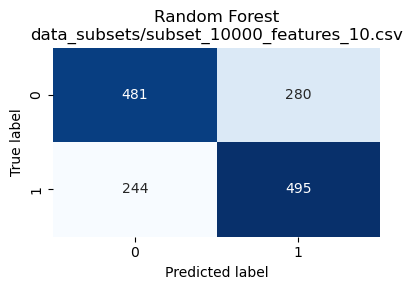

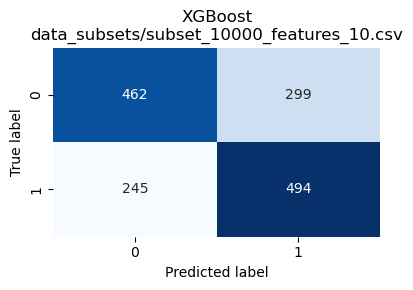

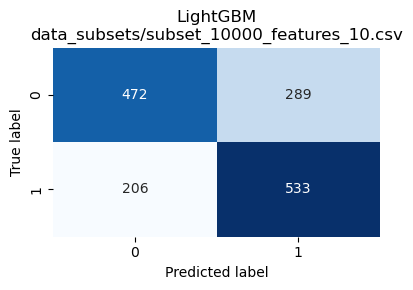

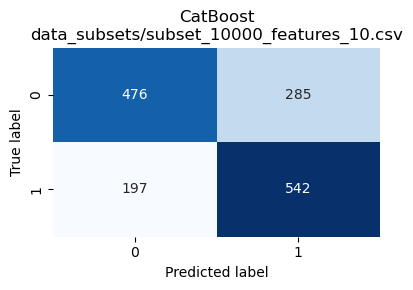

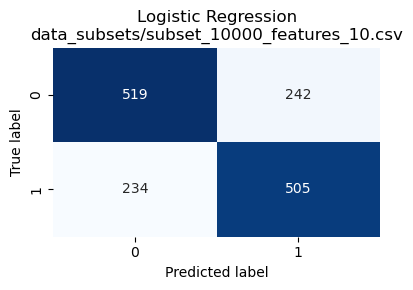

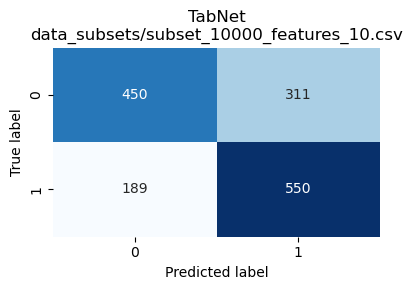

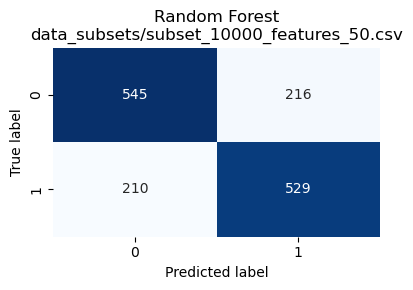

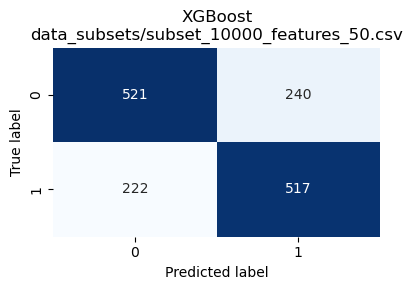

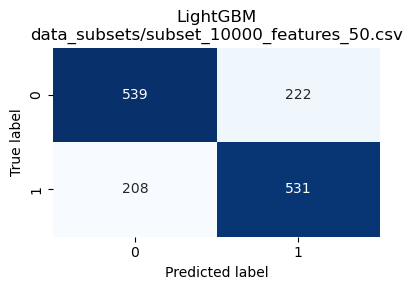

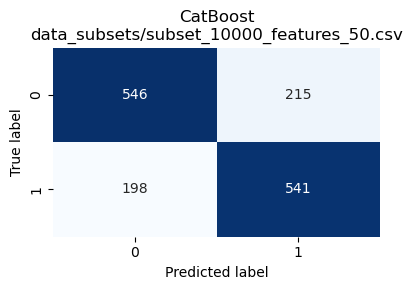

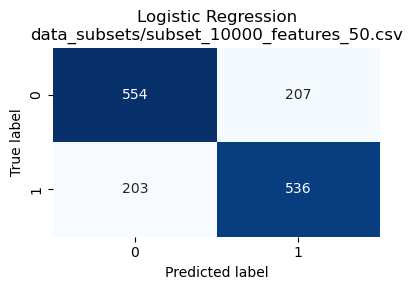

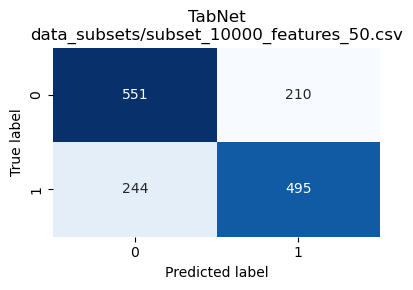

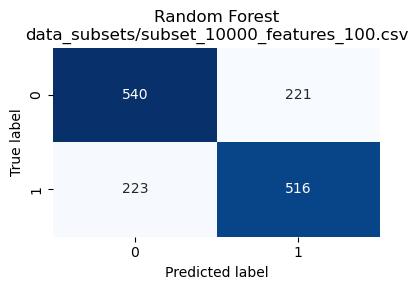

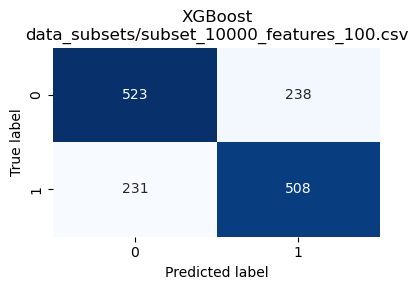

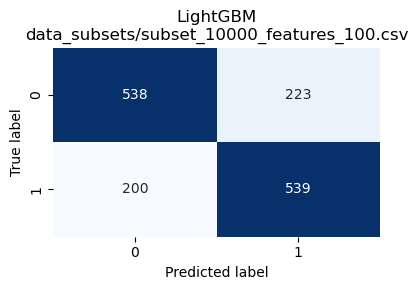

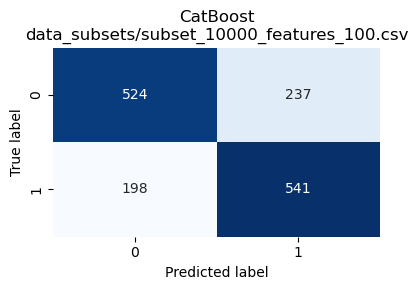

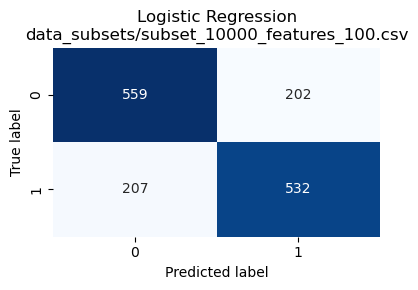

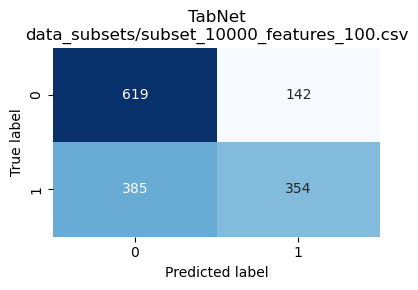

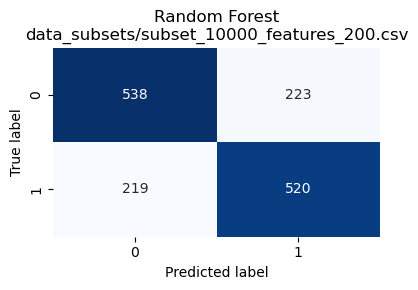

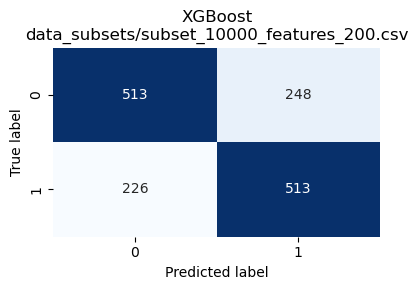

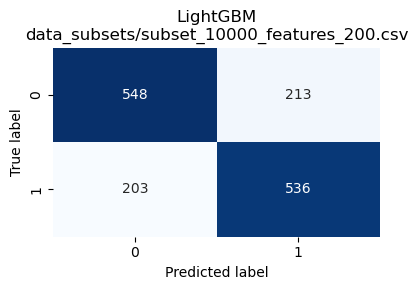

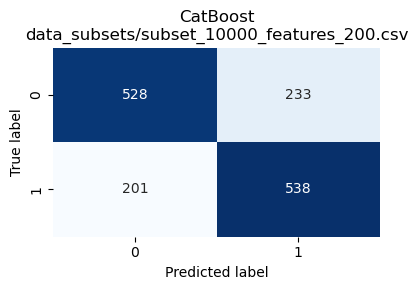

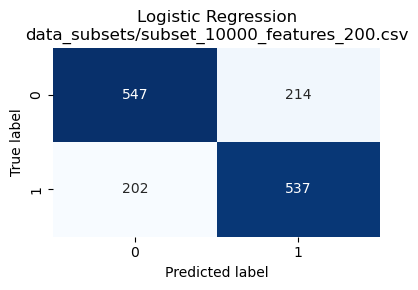

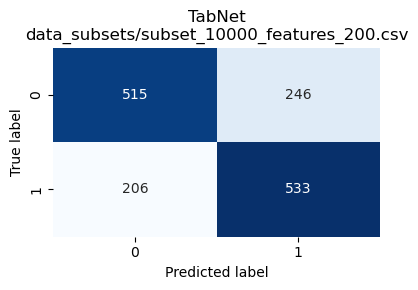

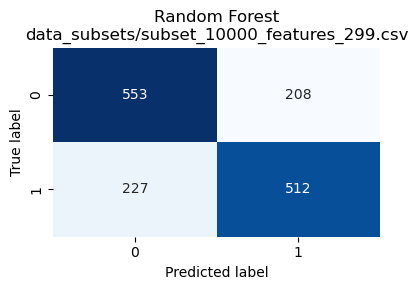

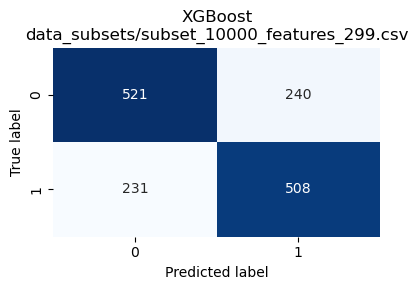

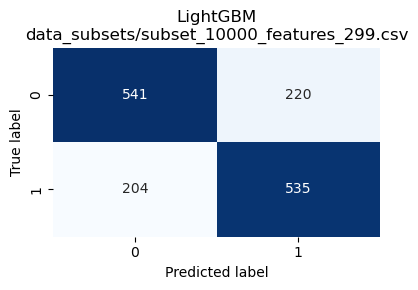

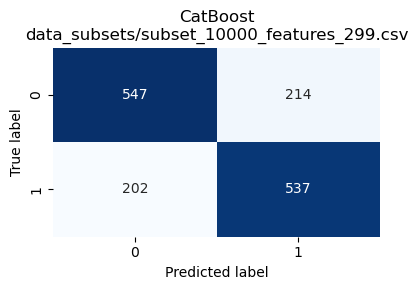

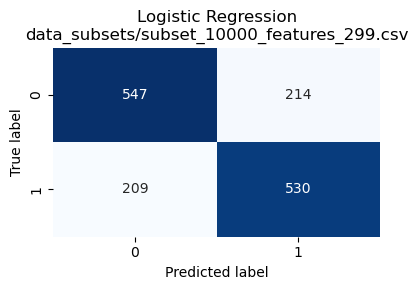

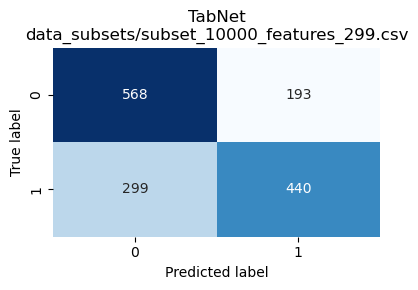

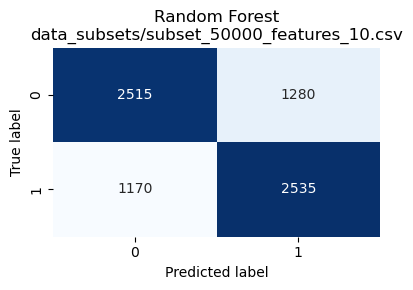

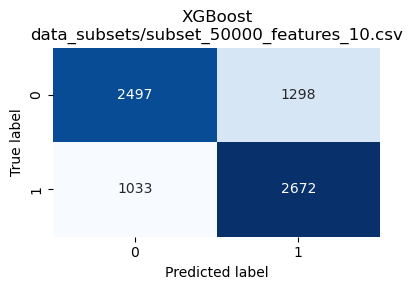

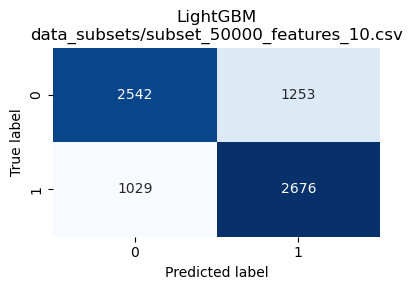

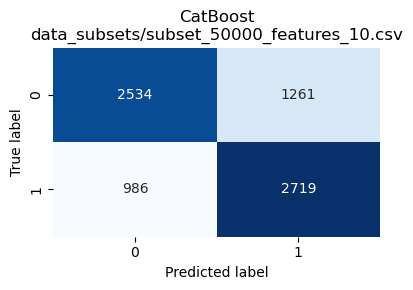

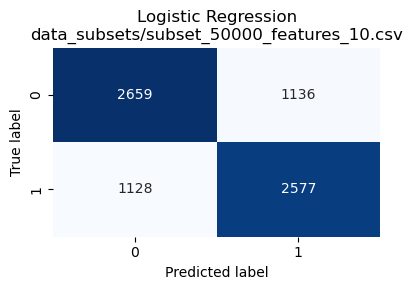

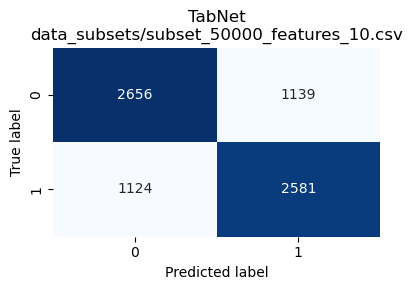

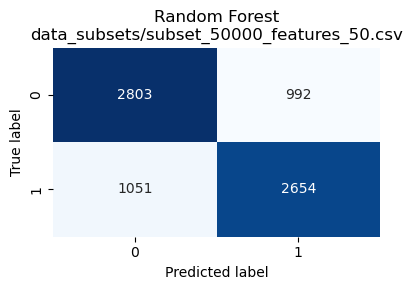

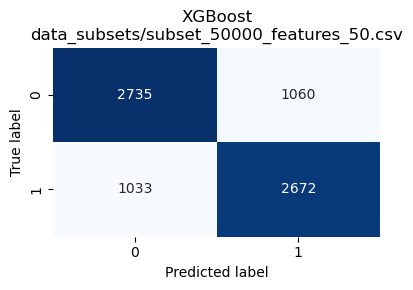

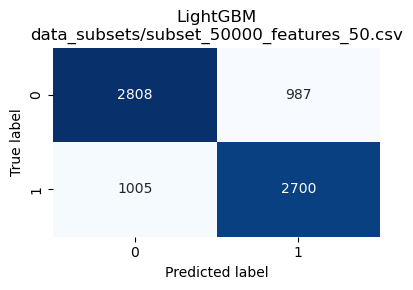

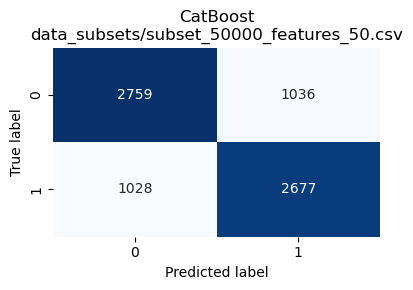

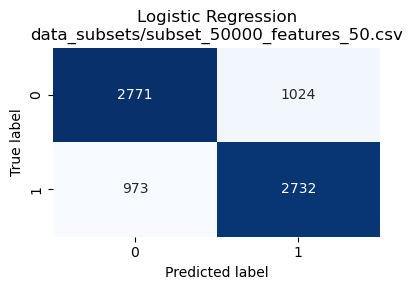

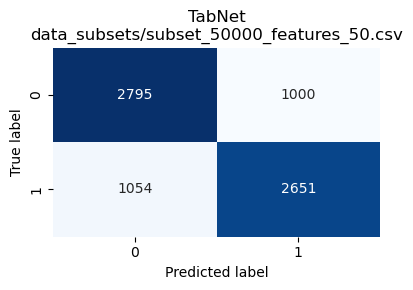

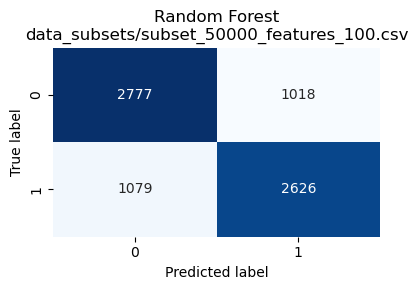

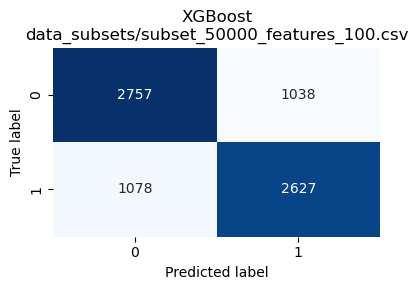

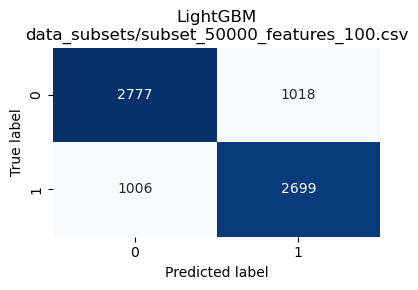

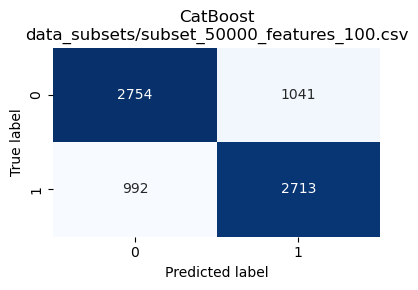

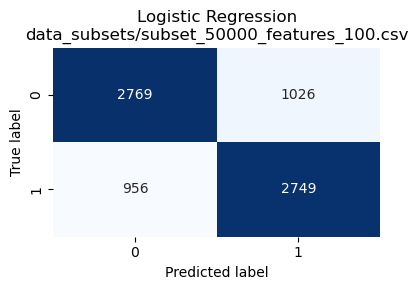

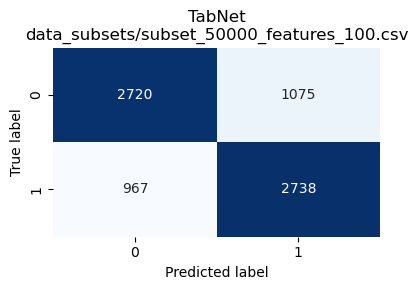

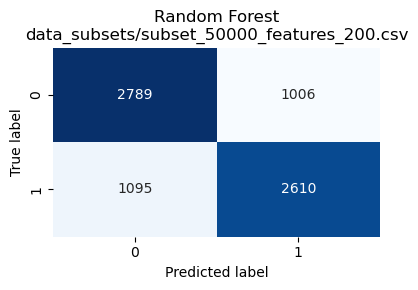

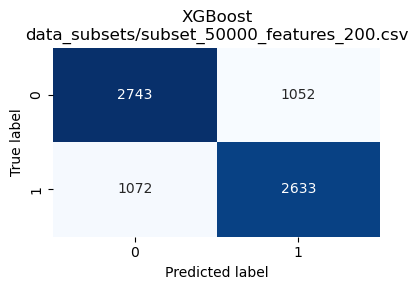

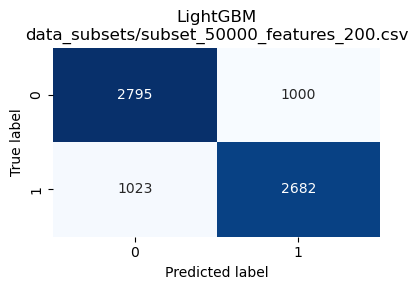

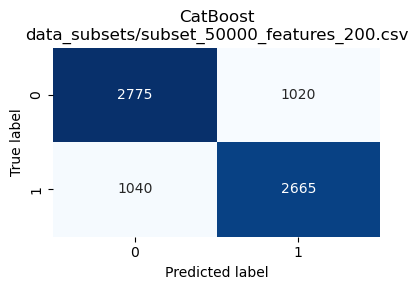

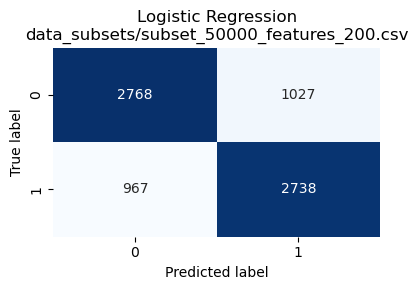

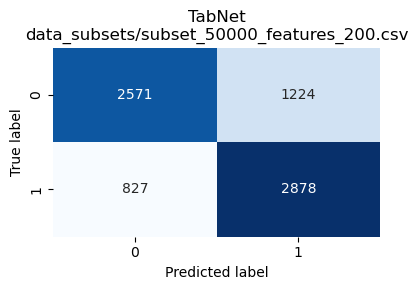

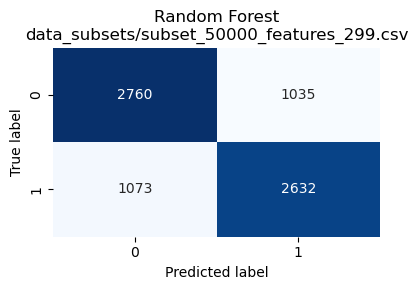

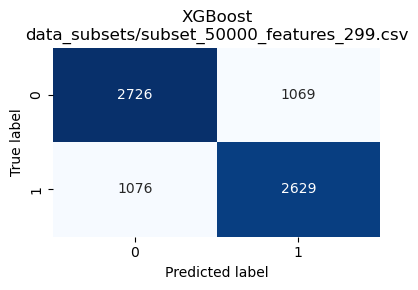

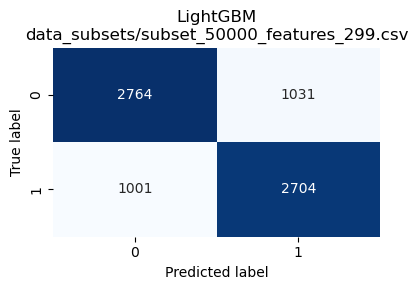

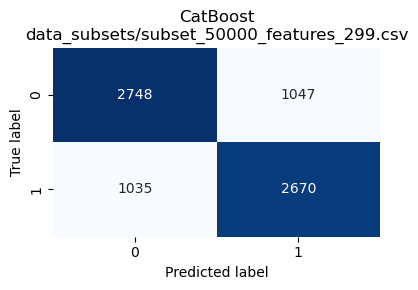

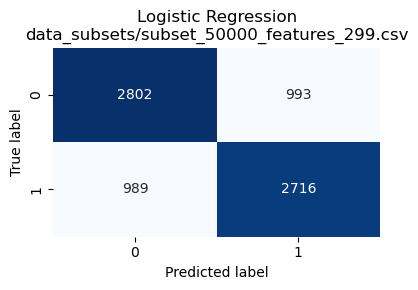

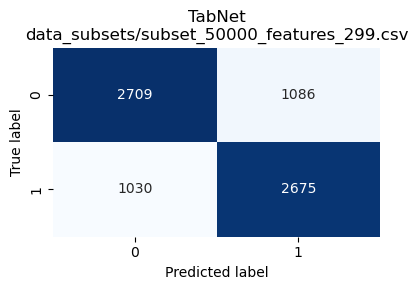

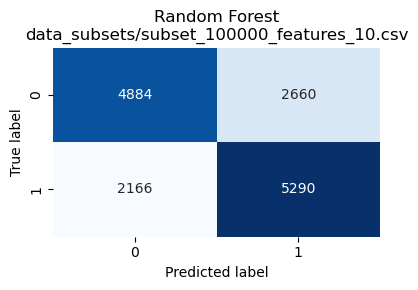

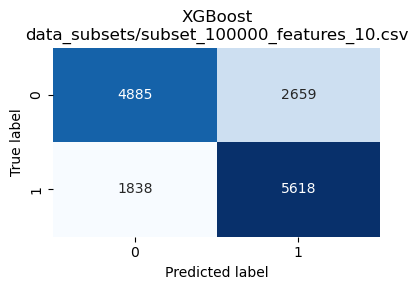

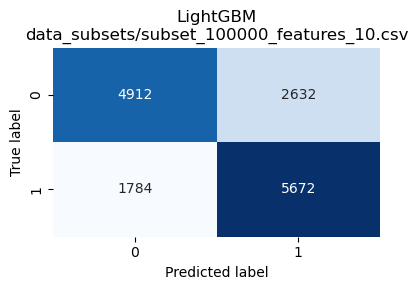

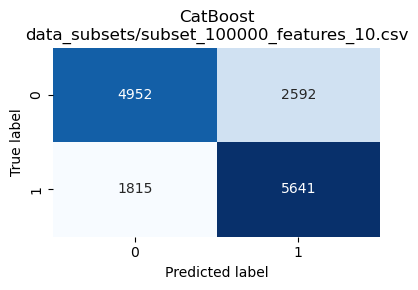

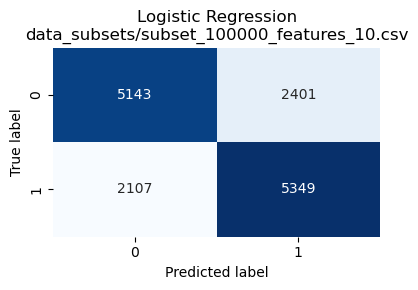

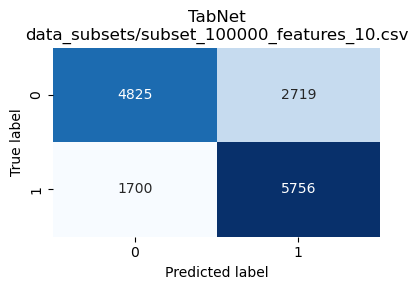

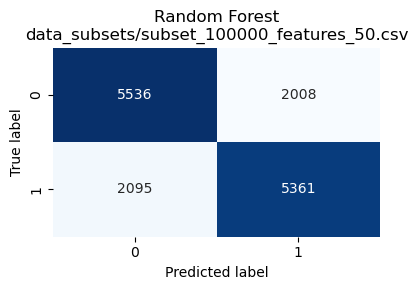

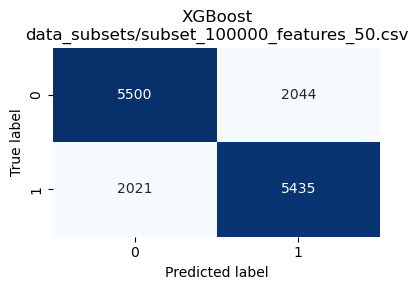

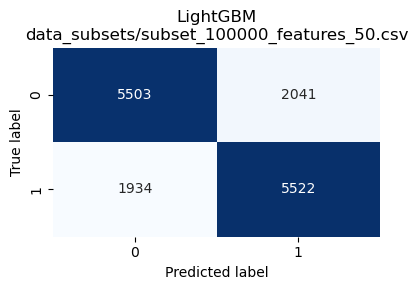

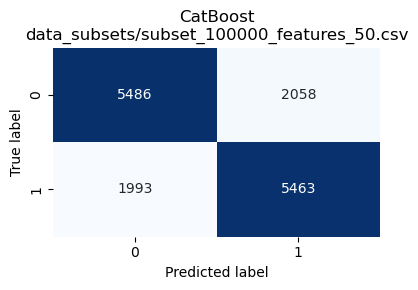

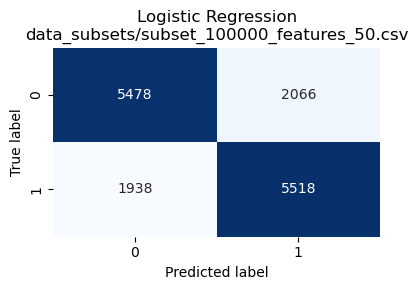

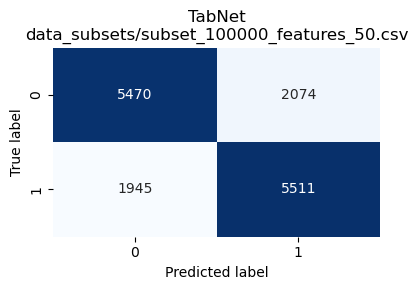

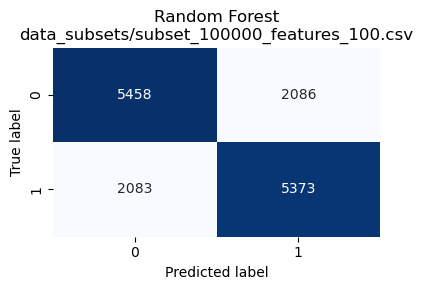

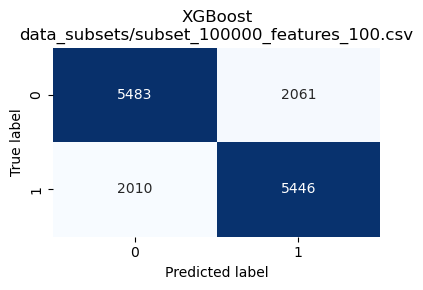

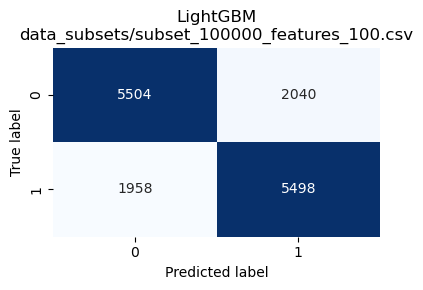

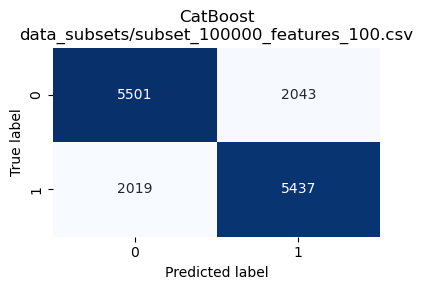

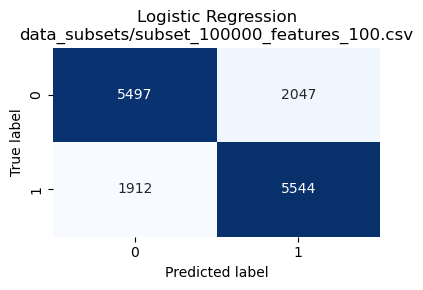

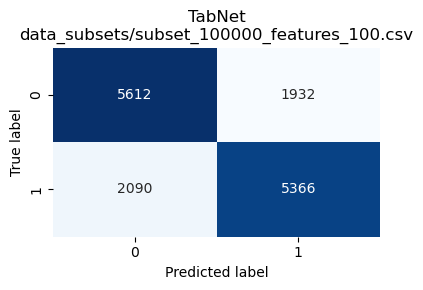

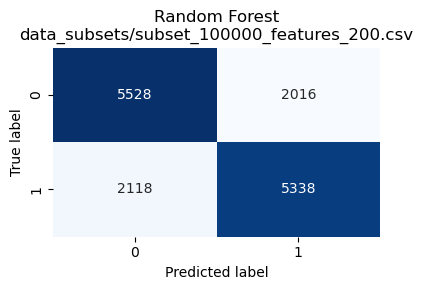

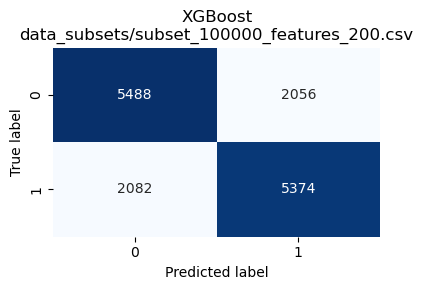

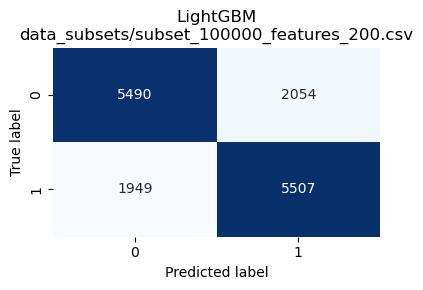

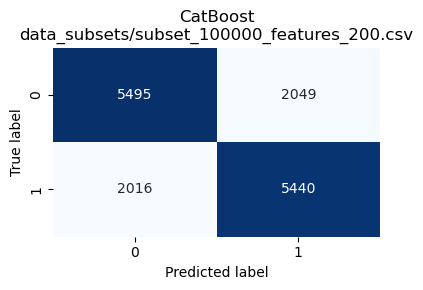

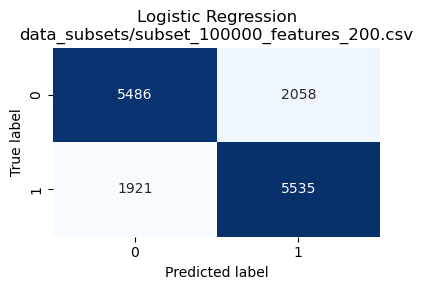

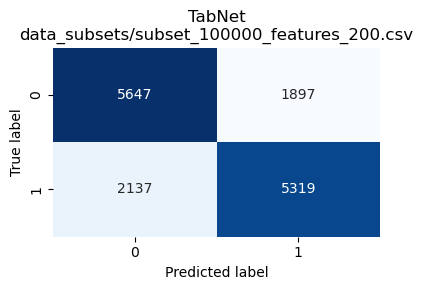

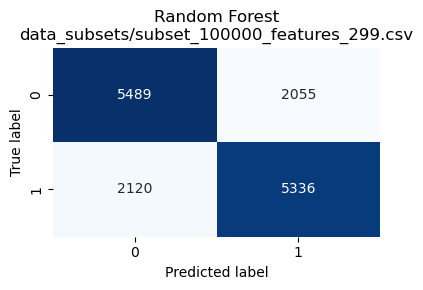

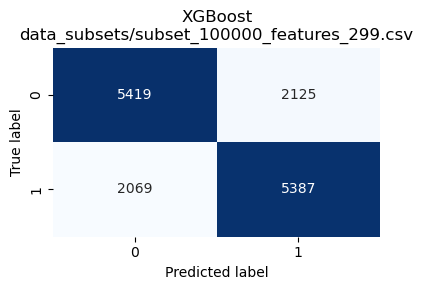

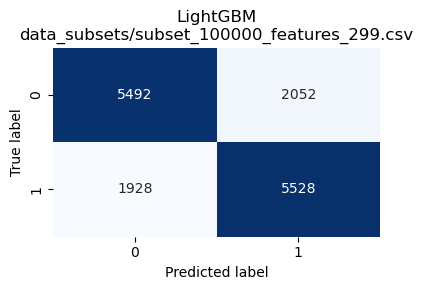

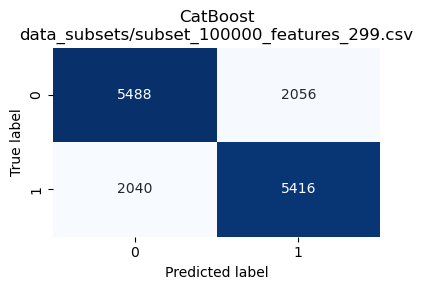

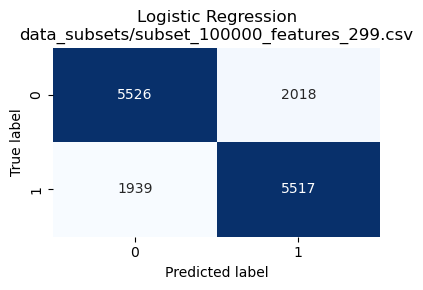

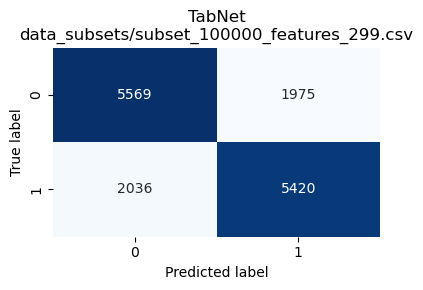

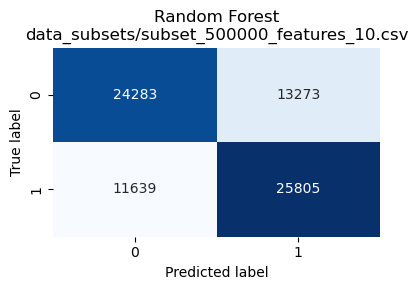

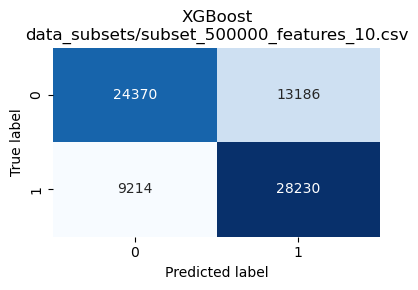

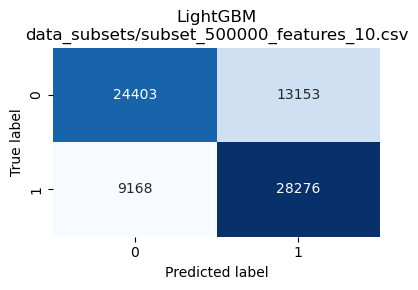

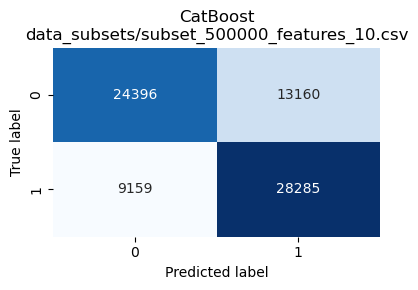

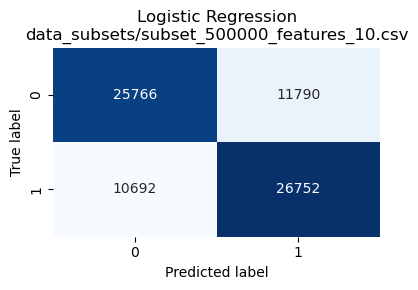

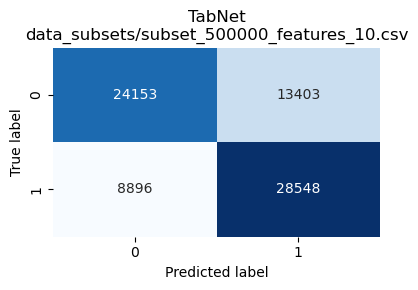

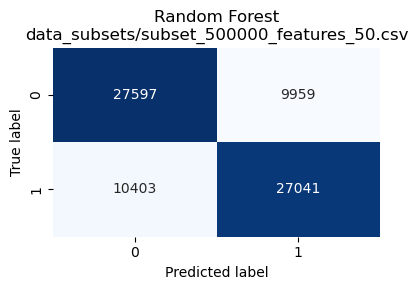

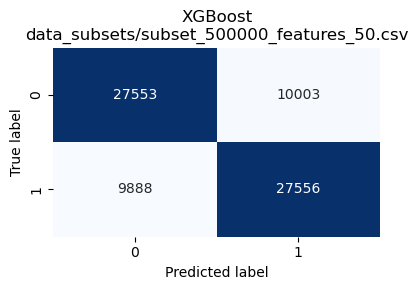

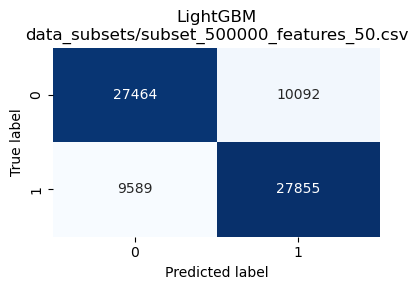

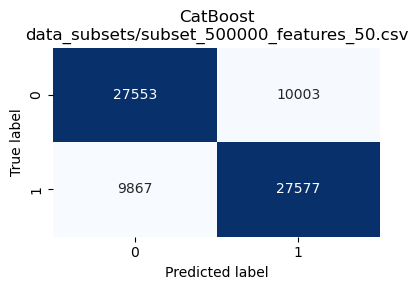

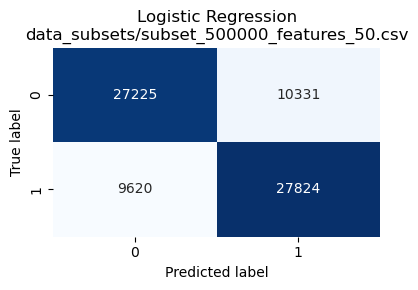

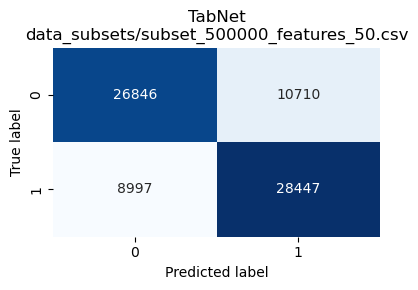

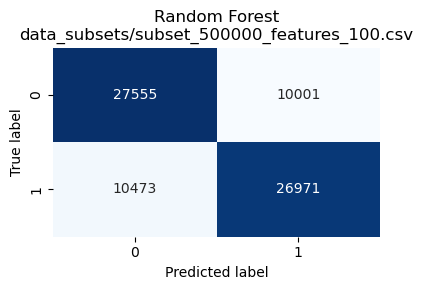

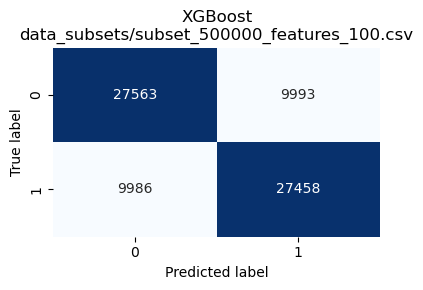

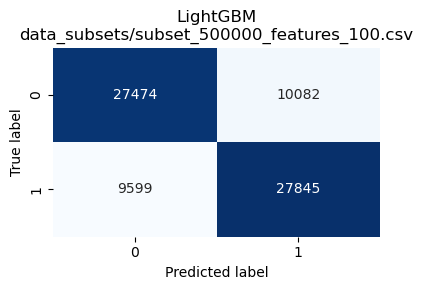

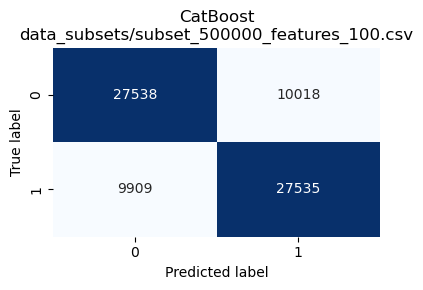

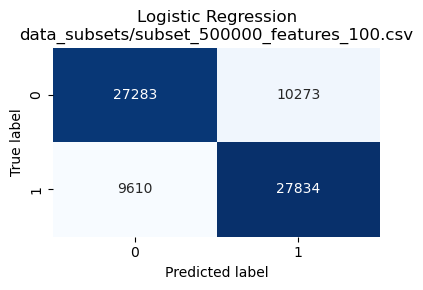

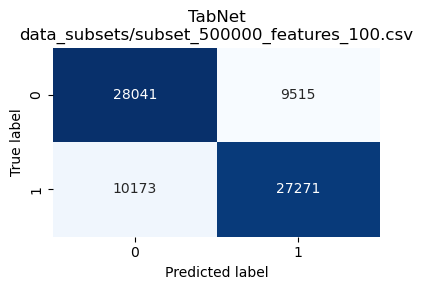

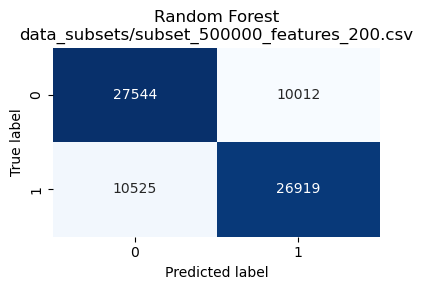

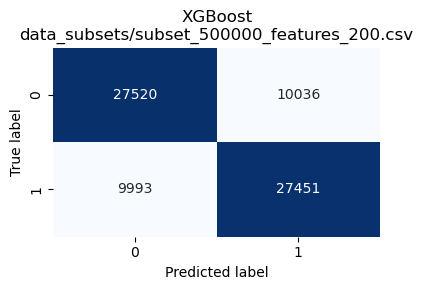

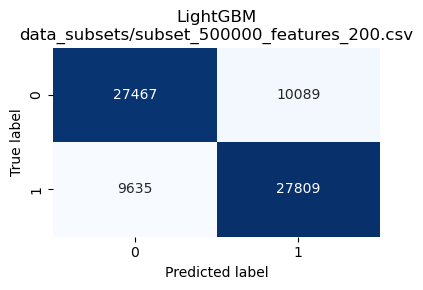

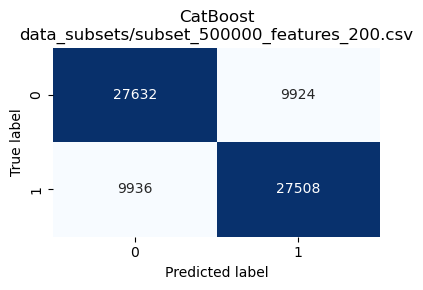

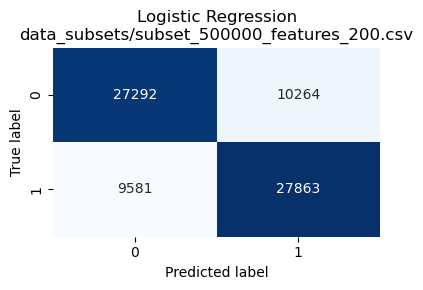

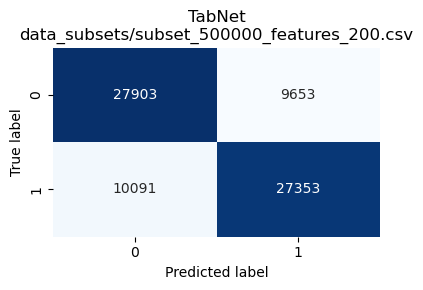

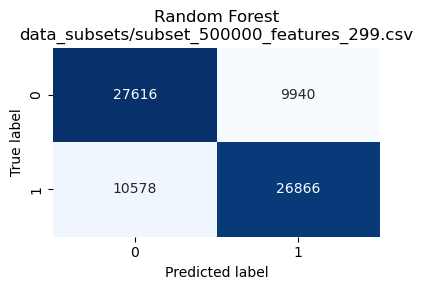

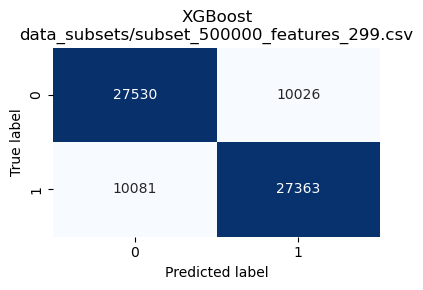

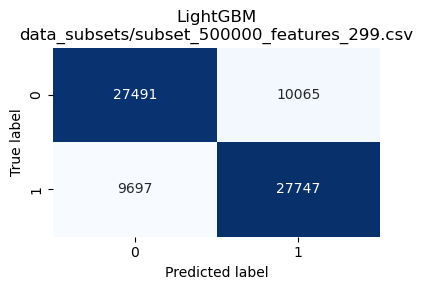

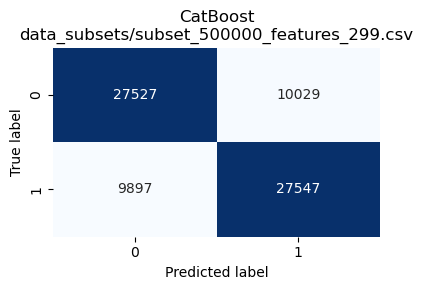

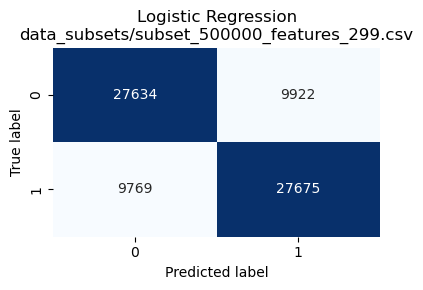

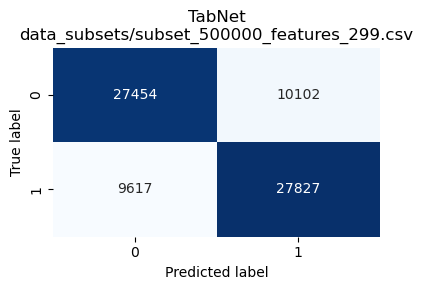

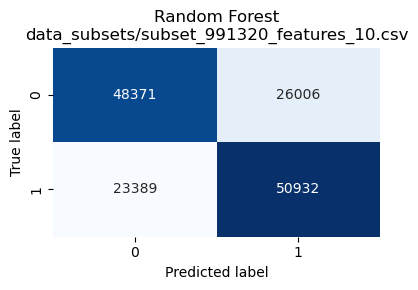

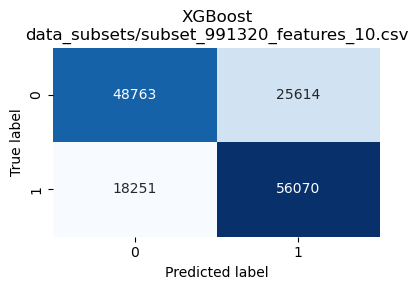

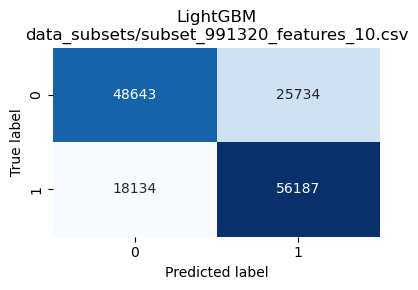

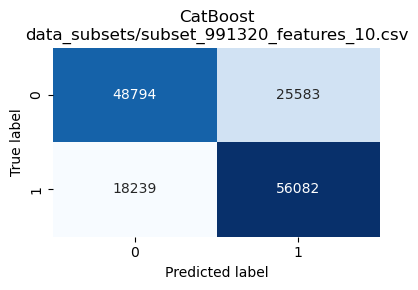

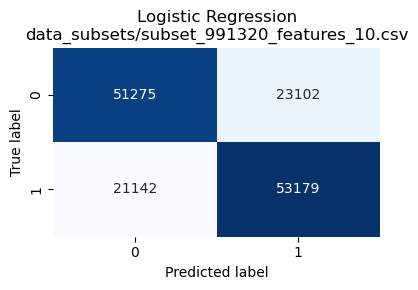

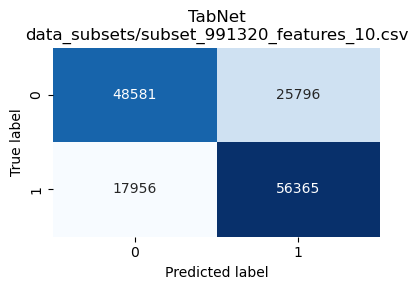

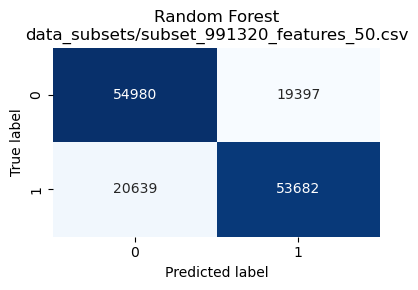

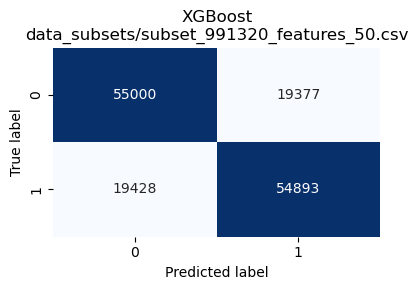

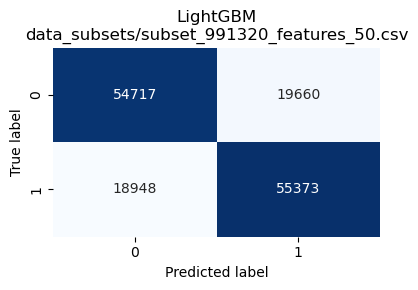

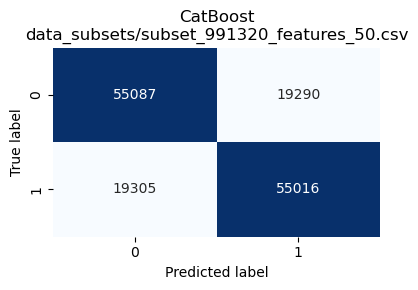

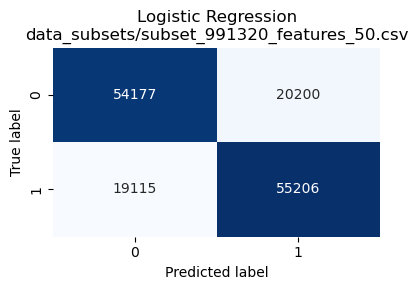

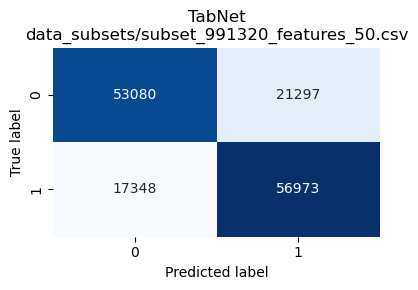

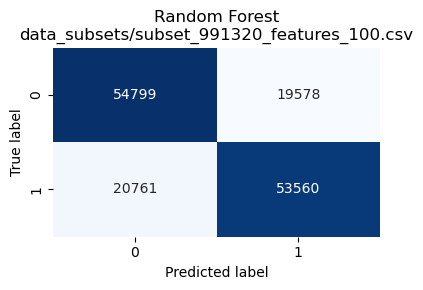

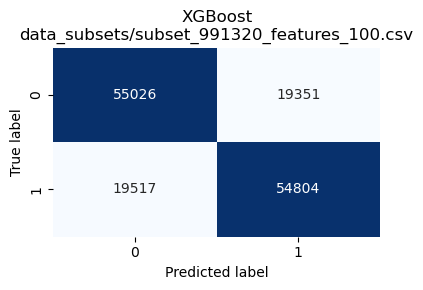

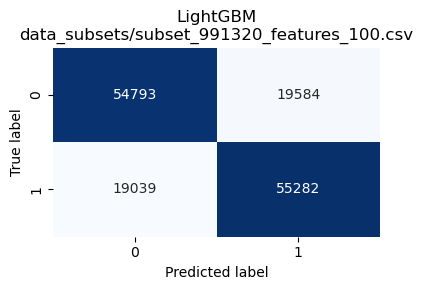

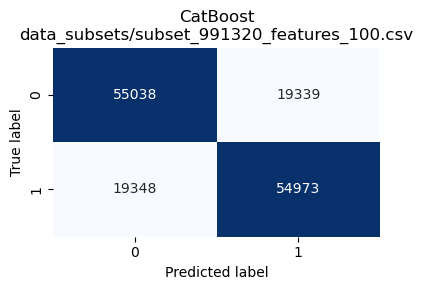

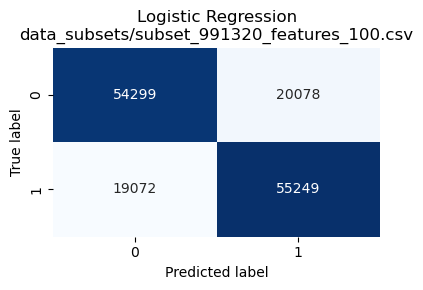

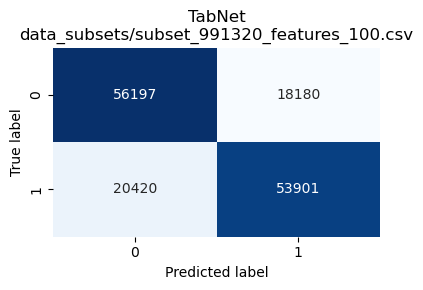

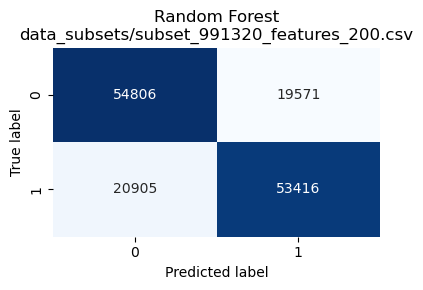

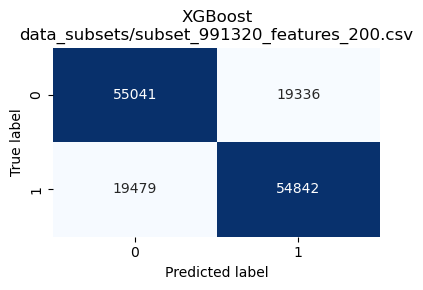

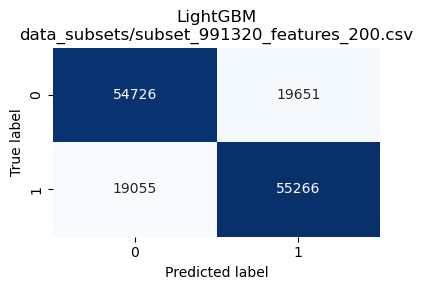

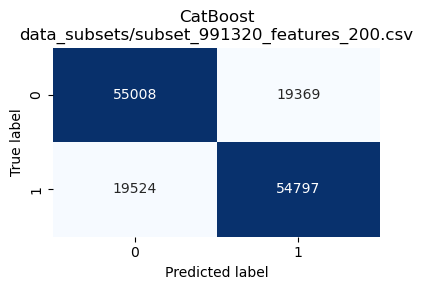

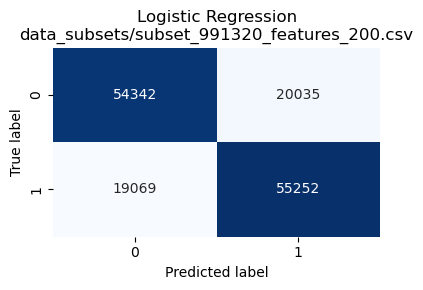

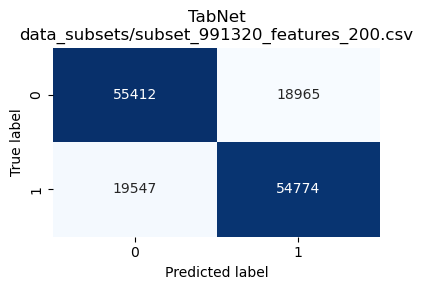

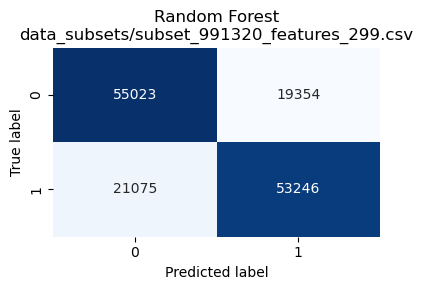

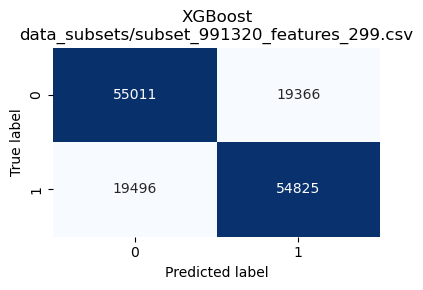

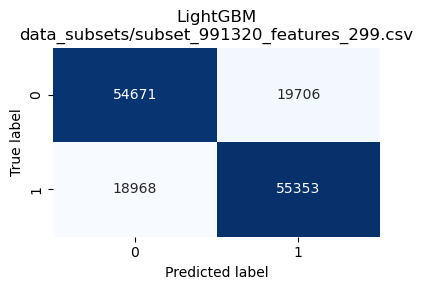

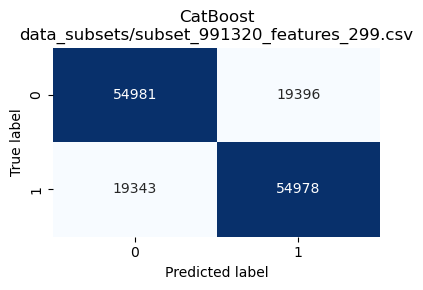

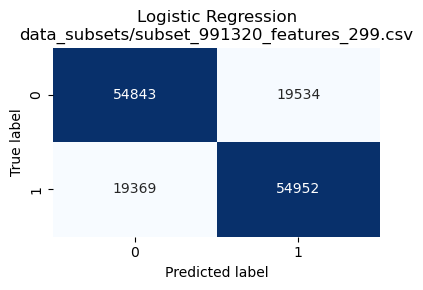

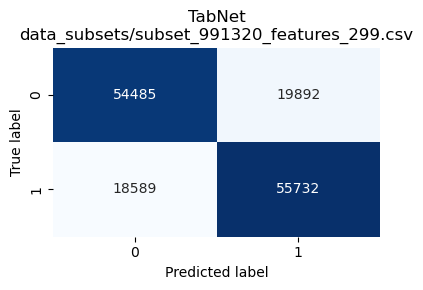

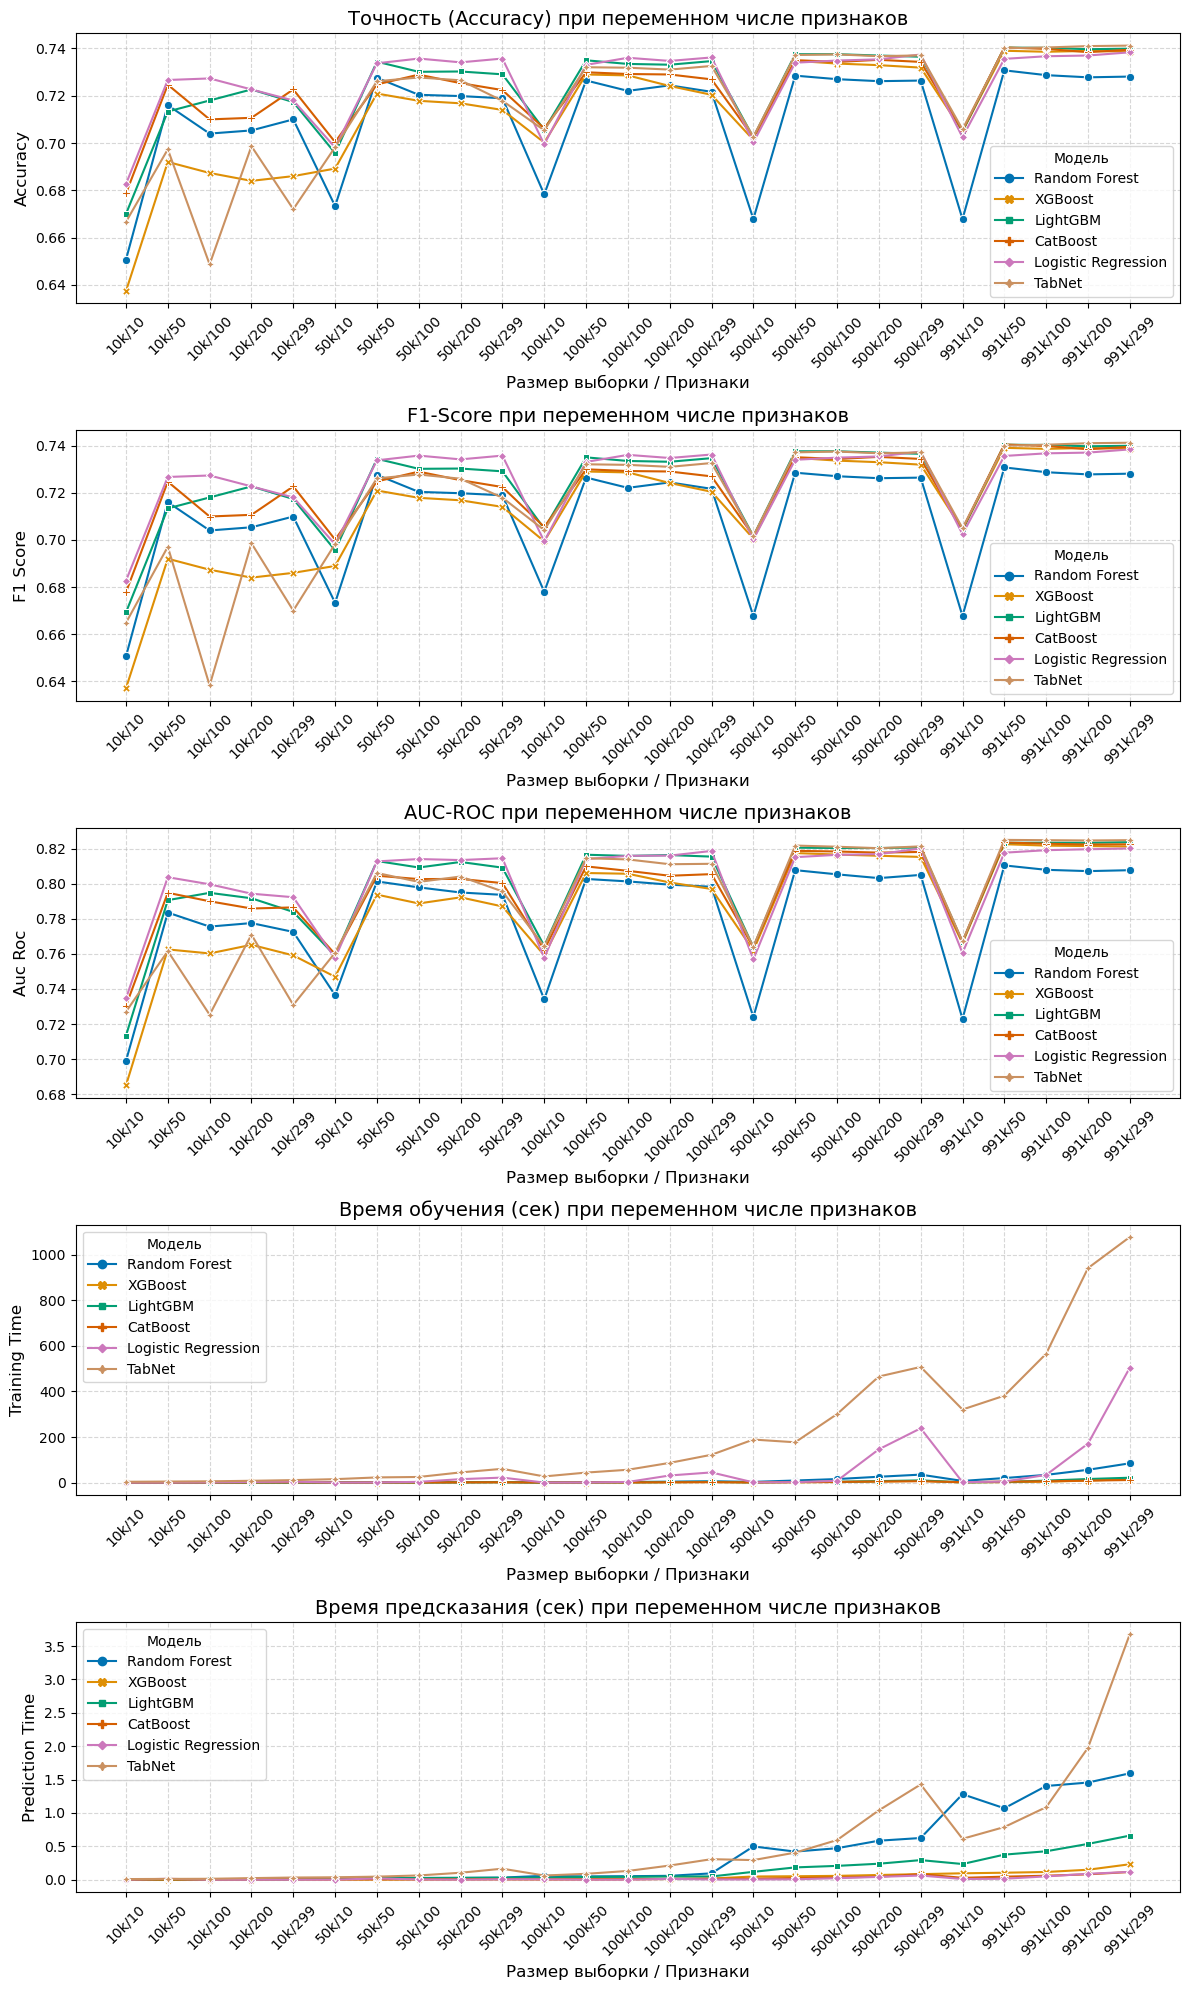

In [5]:
results_list_2 = []
for key, value in all_results_var_features.items():
    model_name, file = key.split("_", 1)
    results_list_2.append({
        "model": model_name,
        "file": file,
        "accuracy": value["accuracy"],
        "f1_score": value["f1_score"],
        "auc_roc": value["auc_roc"],
        "training_time": value.get("training_time", None),
        "prediction_time": value.get("prediction_time", None),
        "confusion_matrix": value.get("confusion_matrix", None)
    })

results_df_2 = pd.DataFrame(results_list_2)
results_df_2 = rename_file_column(results_df_2)

print("=" * 80)
print("CONFUSION MATRICES: files_2")
print("=" * 80)

for key, value in all_results_var_features.items():
    cm = value.get("confusion_matrix", None)
    if cm is None:
        continue

    model_name, file_name = key.split("_", 1)
    plot_confusion_matrix(
        cm=cm,
        model_name=model_name,
        file_name=file_name
    )

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20))

for idx, ax in enumerate(axes):
    metric = metrics[idx]
    
    if metric not in results_df_2.columns:
        continue
    
    sns.lineplot(
        data=results_df_2,
        x='file',
        y=metric,
        hue='model',
        style='model',
        markers=True,
        dashes=False,
        palette=palette,
        ax=ax
    )
    
    ax.set_title(f"{plot_titles[idx]} при переменном числе признаков", fontsize=14)
    ax.set_xlabel('Размер выборки / Признаки', fontsize=12)
    ax.set_ylabel(metric.replace("_", " ").title(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Модель', loc='best')

plt.tight_layout()
plt.show()

### Итоговые таблицы (files_2)

Формируем итоговые таблицы сравнения моделей при переменном числе признаков.

In [6]:
print("Итоговые таблицы по метрикам для каждого файла (files_2)")

for metric in metrics_for_tables:
    print(f"Топ моделей по {metric.replace('_', ' ').title()}")
    
    metric_table = results_df_2[["model", "file", metric]].copy()
    metric_table = metric_table.dropna(subset=[metric])
    metric_table = metric_table.sort_values(by=metric, ascending=False)
    
    table_str = tabulate(metric_table, headers='keys', tablefmt='github', showindex=False, floatfmt=".4f")
    print(table_str)
    print("\n")

Итоговые таблицы по метрикам для каждого файла (files_2)
Топ моделей по Accuracy
| model               | file     |   accuracy |
|---------------------|----------|------------|
| TabNet              | 991k/299 |     0.7412 |
| TabNet              | 991k/200 |     0.7410 |
| CatBoost            | 991k/50  |     0.7404 |
| TabNet              | 991k/100 |     0.7404 |
| LightGBM            | 991k/50  |     0.7404 |
| LightGBM            | 991k/100 |     0.7403 |
| TabNet              | 991k/50  |     0.7401 |
| LightGBM            | 991k/299 |     0.7399 |
| CatBoost            | 991k/100 |     0.7398 |
| LightGBM            | 991k/200 |     0.7397 |
| CatBoost            | 991k/299 |     0.7395 |
| XGBoost             | 991k/50  |     0.7390 |
| XGBoost             | 991k/200 |     0.7390 |
| XGBoost             | 991k/299 |     0.7387 |
| XGBoost             | 991k/100 |     0.7386 |
| CatBoost            | 991k/200 |     0.7384 |
| Logistic Regression | 991k/299 |     0.7384 |
| Light

# 